# Lab Assignment 2 
## Signature
-----
Alexandre Dufresne-Nappert

20948586

## Tasks
-----

 1. Antiferromagnetic case (J = –1) — Reproduce Figure 10.2 for an antiferromagnet and compare with the
 ferromagnetic case.

 2. Equilibrium analysis — Test if 2000 sweeps are sufficient to reach equilibrium by plotting energy and
 magnetization vs. sweep number at several temperatures.
 
 3. External magnetic field — Modify the model to include a field term (with $g\cdot \mu_B\cdot H = 1$) and study its impact
 on energy, magnetization, heat capacity, and susceptibility.

## Deliverables
-----
Submit a Jupyter Notebook that includes:
- Code (based on Listing 10.1)
- Plots and numerical analysis for each task
- Short discussion of results and physical interpretation


# Imports
-----

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import rand, randint, permutation
from numba import njit

# Global Number Values
-----

In [2]:
# Define Number of Points and How many subsimulations to Average for that point
Points = 30
Averaging = 5

# Define the Magnetic Info and Temperature
SpinSites = 100
N = SpinSites**2  

# Function Definitions (From Code Provided)
----
## Notes
-----
I've reorganized the code so that functions are defined at the beginning, I've also optimized the code by having variables passed through by reference instead of using global accesses. 

Most importantly I added the Numba package to make the code compile to C using JIT compilation (Just In Time compilation) so that the code runs as if it is closer to a compiled language granting an overall 120x + speedup (Measured on my PC)

I've also shared this optimized snippet with the rest of the class, but note that I am the original author for this snippet

In [3]:
# Function to change indexes to subscripts ---------------------------------
@njit
def ind2sub(indx, L):
    """Returns the Row and Column based on the Index
    
    Parameters:
        indx - Index of the trial to return the row and column of
        L - Number of Spin Sites
    
    Return:
        row - Row Index
        column - Column Index
    """
    column = np.floor(indx / L)
    row = indx - column * L
    return row, column

# Metropolis algorithm function --------------------------------------------
@njit
def Metropolis(rowsub, colsub, trial, Spins, eqbmstart, N, T, L, J):
    """Runs the Metropolis Algorithm for trial Modifications for a Systems Spin States
    
    Parameters:
        rowsub - Row Index
        colsub - Column Index
        trial - Trial Number Index
        Spins - 2D LxL Matrix of the Spin States (Modified in Place)
        eqbmstart - Number of Trials we equilibriate for
        N - Total Number of Spin Sites (L^2)
        T - Temperature of the System
        L - Number of Spin Sites 
        J - Ising Number, determining if System is AntiFerromagnetic or Magnetic
        
    Returns:
        Energy - Energy of the System
    """
    inverseT = 1/T
    Energy = 0.0
    for counter in range(N):  # for every spin site
        r = int(rowsub[counter])

        lo = r - 1
        if lo < 0:
            lo = L - 1

        hi = r + 1
        if hi > L - 1:
            hi = 0

        c = int(colsub[counter])

        lf = c - 1
        if lf < 0:
            lf = L - 1

        rt = c + 1
        if rt > L - 1:
            rt = 0

        # Sum neighbouring spins
        SS = Spins[lo, c] + Spins[hi, c] + Spins[r, lf] + Spins[r, rt]
        # Energy change if flipped
        DeltaE = 2 * J * SS * Spins[r, c]
        # Metropolis
        if DeltaE < 0 or rand() < np.exp(-DeltaE * inverseT):
            Spins[r, c] = -Spins[r, c]
        if trial >= eqbmstart:
            Energy = Energy - 0.5 * J * SS * Spins[r, c]
    return Energy

@njit
def RunMonteCarloTrials(Spins, eqbmstart, neq, trials, N, T, L, J):
    """Runs the Metropolis Monte Carlo Trials over the course of eqbmstart + neq steps
    
    Parameters:
        Spins - 2D LxL Matrix of the Spin States (Modified in Place)
        eqbmstart - Number of Trials we equilibriate for
        neq - Number of Trials to run after Equilibriation
        N - Total Number of Spin Sites (L^2)
        T - Temperature of the System
        L - Number of Spin Sites 
        J - Ising Number, determining if System is AntiFerromagnetic or Magnetic
        
    Returns:
        Eav - Average Energy of the MonteCarlo Simulation
        Cv - Specific Heat Capacity of the MonteCarlo Simulation
        Mav - Average Magnetization of the MonteCarlo Simulation
        Chi - Susceptability of the MonteCarlo Simulation
    """
    M = np.zeros(neq)
    E = np.zeros(neq)

    # Perform Monte-Carlo trials -----------------------------------------------
    for trial in range(trials):
        indx = permutation(N)
        rowsub, colsub = ind2sub(indx, L)
        Energy = Metropolis(rowsub, colsub, trial, Spins, eqbmstart, N, T, L, J)
        if trial >= eqbmstart:
            t = trial - eqbmstart
            E[t] = Energy
            M[t] = np.sum(Spins)
            
    # Results -------------------------------------------------------------------
    Eav = np.mean(E) / N
    Cv = (np.var(E) / T**2) / N
    Mav = np.mean(M) / N
    Chi = (np.var(M) / T) / N
    
    return [Eav, Cv, Mav, Chi]
        

# Plotting Function Definitions
-----


In [4]:
def plotIsingResults(Data, T, title):
    """
    Plots the Individual Sweeps of the Ising Model Monte Carlo runs, displays the
    Energy, Specific Heat, Magnetisation and Susceptibility in a 2x2 grid like
    in Figure 10.2
    
    Parameters:
        Data - NDArray of the Data to Plot
        T - Temperature Data Points to plot over
        title - Title to use for the Super Title
    """
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    fig.subplots_adjust(hspace=0.35, wspace=0.25)

    for i in range(len(Data[0])):
        # Energy
        axs[0, 0].plot(T, Data[:, i, 0], '--o', linewidth=1.2, markersize=4, label=f"Sweep {i+1}")
        axs[0, 0].set_xlabel("Temperature")
        axs[0, 0].set_ylabel("Average Energy")
        axs[0, 0].grid(True)
        axs[0, 0].legend()
        
        # Specific heat
        axs[0, 1].plot(T, Data[:, i, 1], '--o', linewidth=1.2, markersize=4, label=f"Sweep {i+1}")
        axs[0, 1].set_xlabel("Temperature")
        axs[0, 1].set_ylabel("Specific heat")
        axs[0, 1].grid(True)
        axs[0, 1].legend()

        # Magnetisation
        axs[1, 0].plot(T, Data[:, i, 2], '--o', linewidth=1.2, markersize=4, label=f"Sweep {i+1}")
        axs[1, 0].set_xlabel("Temperature")
        axs[1, 0].set_ylabel("Average Magnetisation")
        axs[1, 0].grid(True)
        axs[1, 0].legend()

        # Susceptibility
        axs[1, 1].plot(T, Data[:, i, 3], '--o', linewidth=1.2, markersize=4, label=f"Sweep {i+1}")
        axs[1, 1].set_xlabel("Temperature")
        axs[1, 1].set_ylabel("Susceptibility")
        axs[1, 1].grid(True)
        axs[1, 1].legend()
    
    fig.suptitle(title, fontsize=18, fontweight='bold')

    plt.show()

def plotAverageIsingResults(Data, T, title):
    """
    Plots the Average of all Sweeps of the Ising Model Monte Carlo runs, displays the
    Energy, Specific Heat, Magnetisation and Susceptibility in a 2x2 grid like
    in Figure 10.2
    
    Parameters:
        Data - NDArray of the Data to Plot
        T - Temperature Data Points to plot over
        title - Title to use for the Super Title
    """
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    fig.subplots_adjust(hspace=0.35, wspace=0.25)

    # Energy
    axs[0, 0].plot(T, Data.mean(axis=1)[:, 0], 'r--o', linewidth=1.2, markersize=4)
    axs[0, 0].set_xlabel("Temperature")
    axs[0, 0].set_ylabel("Average Energy")
    axs[0, 0].grid(True)

    # Specific heat
    axs[0, 1].plot(T, Data.mean(axis=1)[:, 1], 'g--o', linewidth=1.2, markersize=4)
    axs[0, 1].set_xlabel("Temperature")
    axs[0, 1].set_ylabel("Specific heat")
    axs[0, 1].grid(True)

    # Magnetisation
    axs[1, 0].plot(T, Data.mean(axis=1)[:, 2], 'b--o', linewidth=1.2, markersize=4)
    axs[1, 0].set_xlabel("Temperature")
    axs[1, 0].set_ylabel("Average Magnetisation")
    axs[1, 0].grid(True)

    # Susceptibility
    axs[1, 1].plot(T, Data.mean(axis=1)[:, 3], 'm--o', linewidth=1.2, markersize=4)
    axs[1, 1].set_xlabel("Temperature")
    axs[1, 1].set_ylabel("Susceptibility")
    axs[1, 1].grid(True)
    
    fig.suptitle(f"Average {title}", fontsize=18, fontweight='bold')

    plt.show()

def plotEquilibriumAnalysis(DataAntiferro, DataFerro, equilibriation, T, title):
    """
    Plots the Antiferromagnetic and Ferromagntic Energies and Magnetisation values over
    the course of many simulations at different Temperatures, plots the categories 
    onto a single graph
    
    Parameters:
        DataAntiferro - NDArray of the AntiFerromagnetic Data to Plot
        DataFerro - NDArray of the Ferromagnetic Data to Plot
        equilibriation - Number of Equilibriation Steps
        T - Temperature Data Points to plot over
        title - Title to use for the Super Title
    """
    fig, axs = plt.subplots(3, 1, figsize=(20, 20))
    
    for k in range(len(T)):
        # Energy
        axs[k].plot(range(0, equilibriation, 5), DataAntiferro[k, 0, 0:-1:5], '--', linewidth=1, markersize=4, label=f"AntiFerromagnetic")
        axs[k].plot(range(0, equilibriation, 5), DataFerro[k, 0, 0:-1:5], '--', linewidth=1, markersize=4, label=f"Ferromagnetic")
        axs[k].set_xlabel("Equilibriation Steps")
        axs[k].set_ylabel("Energy")
        axs[k].grid(True)
        axs[k].set_title(f"Energy of the System over the course of Equilibriation at T={T[k]}")
        axs[k].legend()
    
    fig.suptitle(f"Energy {title}", fontsize=18, fontweight='bold')

    plt.show()
    
    fig, axs = plt.subplots(3, 1, figsize=(20, 20))
    
    for k in range(len(T)):
        # Magnetisation
        axs[k].plot(range(0, equilibriation, 5), DataAntiferro[k, 1, 0:-1:5], '--', linewidth=1, markersize=4, label=f"AntiFerromagnetic")
        axs[k].plot(range(0, equilibriation, 5), DataFerro[k, 1, 0:-1:5], '--', linewidth=1, markersize=4, label=f"Ferromagnetic")
        axs[k].set_xlabel("Equilibriation Steps")
        axs[k].set_ylabel("Magnetisation")
        axs[k].grid(True)
        axs[k].set_title(f"Magnetization of the System over the course of Equilibriation at T={T[k]}")
        axs[k].legend()
    fig.suptitle(f"Magnetization {title}", fontsize=18, fontweight='bold')

    plt.show()
    
def plotIndividualEquilibriumAnalysis(DataAntiferro, DataFerro, equilibriation, T, title):
    """
    Plots the Individual Antiferromagnetic and Ferromagntic Energies and Magnetisation values over
    the course of many simulations at different Temperatures, plots the categories 
    onto a single graph
    
    Parameters:
        DataAntiferro - NDArray of the AntiFerromagnetic Data to Plot
        DataFerro - NDArray of the Ferromagnetic Data to Plot
        equilibriation - Number of Equilibriation Steps
        T - Temperature Data Points to plot over
        title - Title to use for the Super Title
    """
    fig, axs = plt.subplots(3, 1, figsize=(20, 20))
    
    for i in range(len(DataFerro[0])):
        for k in range(len(T)):
            # Energy
            axs[k].plot(range(0, equilibriation, 5), DataAntiferro[k, i, 0, 0:-1:5], '--', linewidth=1, markersize=4, label=f"AntiFerromagnetic Sweep {i}")
            axs[k].plot(range(0, equilibriation, 5), DataFerro[k, i, 0, 0:-1:5], '--', linewidth=1, markersize=4, label=f"Ferromagnetic Sweep {i}")
            axs[k].set_xlabel("Equilibriation Steps")
            axs[k].set_ylabel("Energy")
            axs[k].grid(True)
            axs[k].set_title(f"Energy of the System over the course of Equilibriation at T={T[k]}")
            axs[k].legend()
    
    fig.suptitle(f"Individual Energy {title}", fontsize=18, fontweight='bold')

    plt.show()
    
    fig, axs = plt.subplots(3, 1, figsize=(20, 20))
    for i in range(len(DataFerro[0])):
        for k in range(len(T)):
            # Magnetisation
            axs[k].plot(range(0, equilibriation, 5), DataAntiferro[k,i,  1, 0:-1:5], '--', linewidth=1, markersize=4, label=f"AntiFerromagnetic Sweep {i}")
            axs[k].plot(range(0, equilibriation, 5), DataFerro[k,i,  1, 0:-1:5], '--', linewidth=1, markersize=4, label=f"Ferromagnetic Sweep {i}")
            axs[k].set_xlabel("Equilibriation Steps")
            axs[k].set_ylabel("Magnetisation")
            axs[k].grid(True)
            axs[k].set_title(f"Magnetization of the System over the course of Equilibriation at T={T[k]}")
            axs[k].legend()
            
    fig.suptitle(f"Individual Magnetization {title}", fontsize=18, fontweight='bold')

    plt.show()
    
def plotMagneticFieldResults(DataMagneticField, DataNoMagneticField, T, title):
    """
    Plots the Average of all Sweeps of the Ising Model Monte Carlo runs with and 
    without an External Magnetic Field Applied, displays the Energy, Specific Heat,
    Magnetisation and Susceptibility in a 2x2 grid like in Figure 10.2
    
    Parameters:
        Data - NDArray of the Data to Plot
        T - Temperature Data Points to plot over
        title - Title to use for the Super Title
    """
    fig, axs = plt.subplots(2, 2, figsize=(16, 10))
    fig.subplots_adjust(hspace=0.35, wspace=0.25)

    # Energy
    axs[0, 0].plot(T, DataMagneticField.mean(axis=1)[:, 0], 'r--o', linewidth=1.2, markersize=4, label="With Magnetic Field")
    axs[0, 0].plot(T, DataNoMagneticField.mean(axis=1)[:, 0], 'b--o', linewidth=1.2, markersize=4, label="Without Magnetic Field")
    axs[0, 0].set_xlabel("Temperature")
    axs[0, 0].set_ylabel("Average Energy")
    axs[0, 0].grid(True)
    axs[0, 0].legend()

    # Specific heat
    axs[0, 1].plot(T, DataMagneticField.mean(axis=1)[:, 1], 'r--o', linewidth=1.2, markersize=4, label="With Magnetic Field")
    axs[0, 1].plot(T, DataNoMagneticField.mean(axis=1)[:, 1], 'b--o', linewidth=1.2, markersize=4, label="Without Magnetic Field")
    axs[0, 1].set_xlabel("Temperature")
    axs[0, 1].set_ylabel("Specific heat")
    axs[0, 1].grid(True)
    axs[0, 1].legend()

    # Magnetisation
    axs[1, 0].plot(T, DataMagneticField.mean(axis=1)[:, 2], 'r--o', linewidth=1.2, markersize=4, label="With Magnetic Field")
    axs[1, 0].plot(T, DataNoMagneticField.mean(axis=1)[:, 2], 'b--o', linewidth=1.2, markersize=4, label="Without Magnetic Field")
    axs[1, 0].set_xlabel("Temperature")
    axs[1, 0].set_ylabel("Average Magnetisation")
    axs[1, 0].grid(True)
    axs[1, 0].legend()

    # Susceptibility
    axs[1, 1].plot(T, DataMagneticField.mean(axis=1)[:, 3], 'r--o', linewidth=1.2, markersize=4, label="With Magnetic Field")
    axs[1, 1].plot(T, DataNoMagneticField.mean(axis=1)[:, 3], 'b--o', linewidth=1.2, markersize=4, label="Without Magnetic Field")
    axs[1, 1].set_xlabel("Temperature")
    axs[1, 1].set_ylabel("Susceptibility")
    axs[1, 1].grid(True)
    axs[1, 1].legend()
    
    fig.suptitle(title, fontsize=18, fontweight='bold')

    plt.show()

# Question 1 : Antiferromagnetic Simulation
-----
Reproduce the equivalent of Figure 10.2 from the PDF for an antiferromagnetic system ($J=-1$).
Requirements:
- Modify the sign of $J$ in the provided code.
- Run simulations for several temperatures $T$.
- Plot average magnetization $\langle M \rangle$ and energy $\langle E \rangle$ vs. $T$ .
- Compare behavior to the ferromagnetic case ($J=+1$).

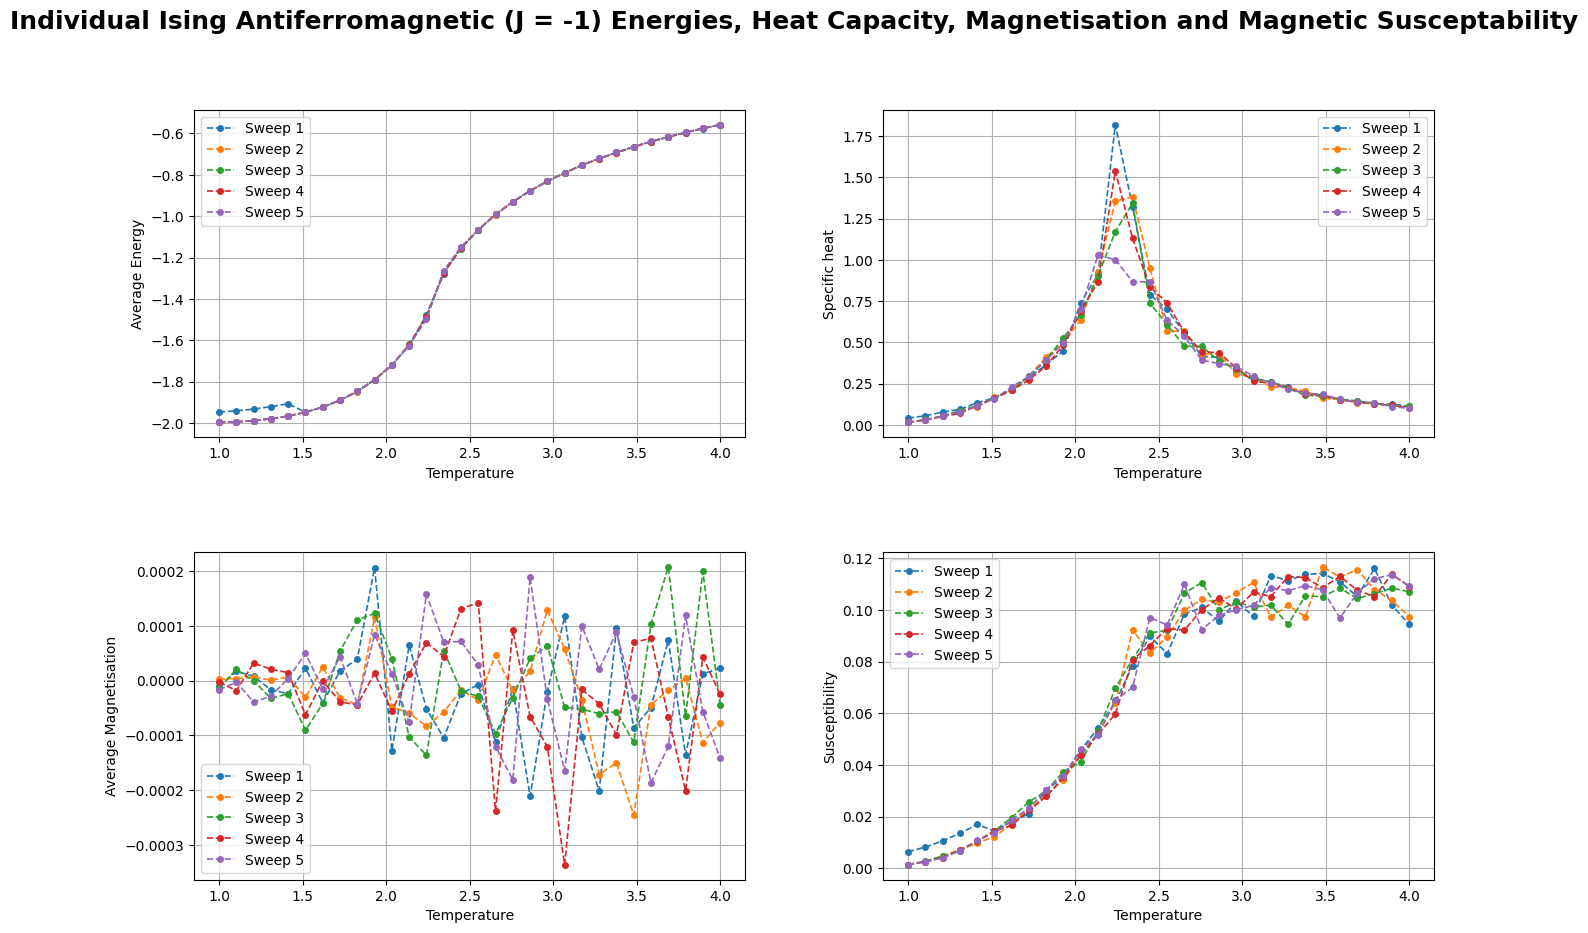

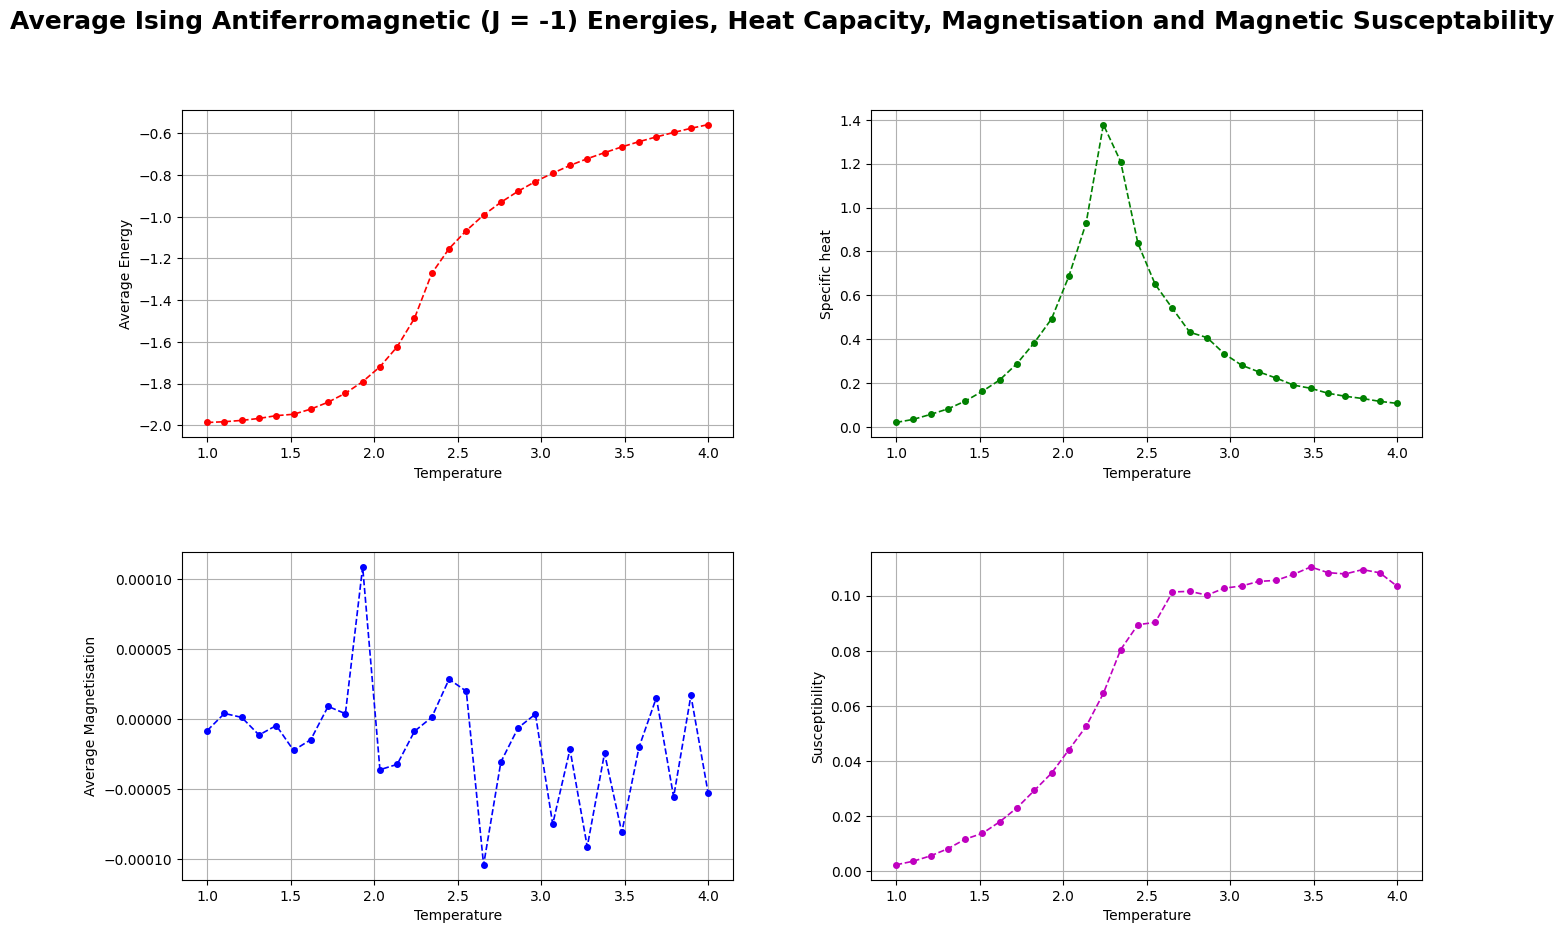

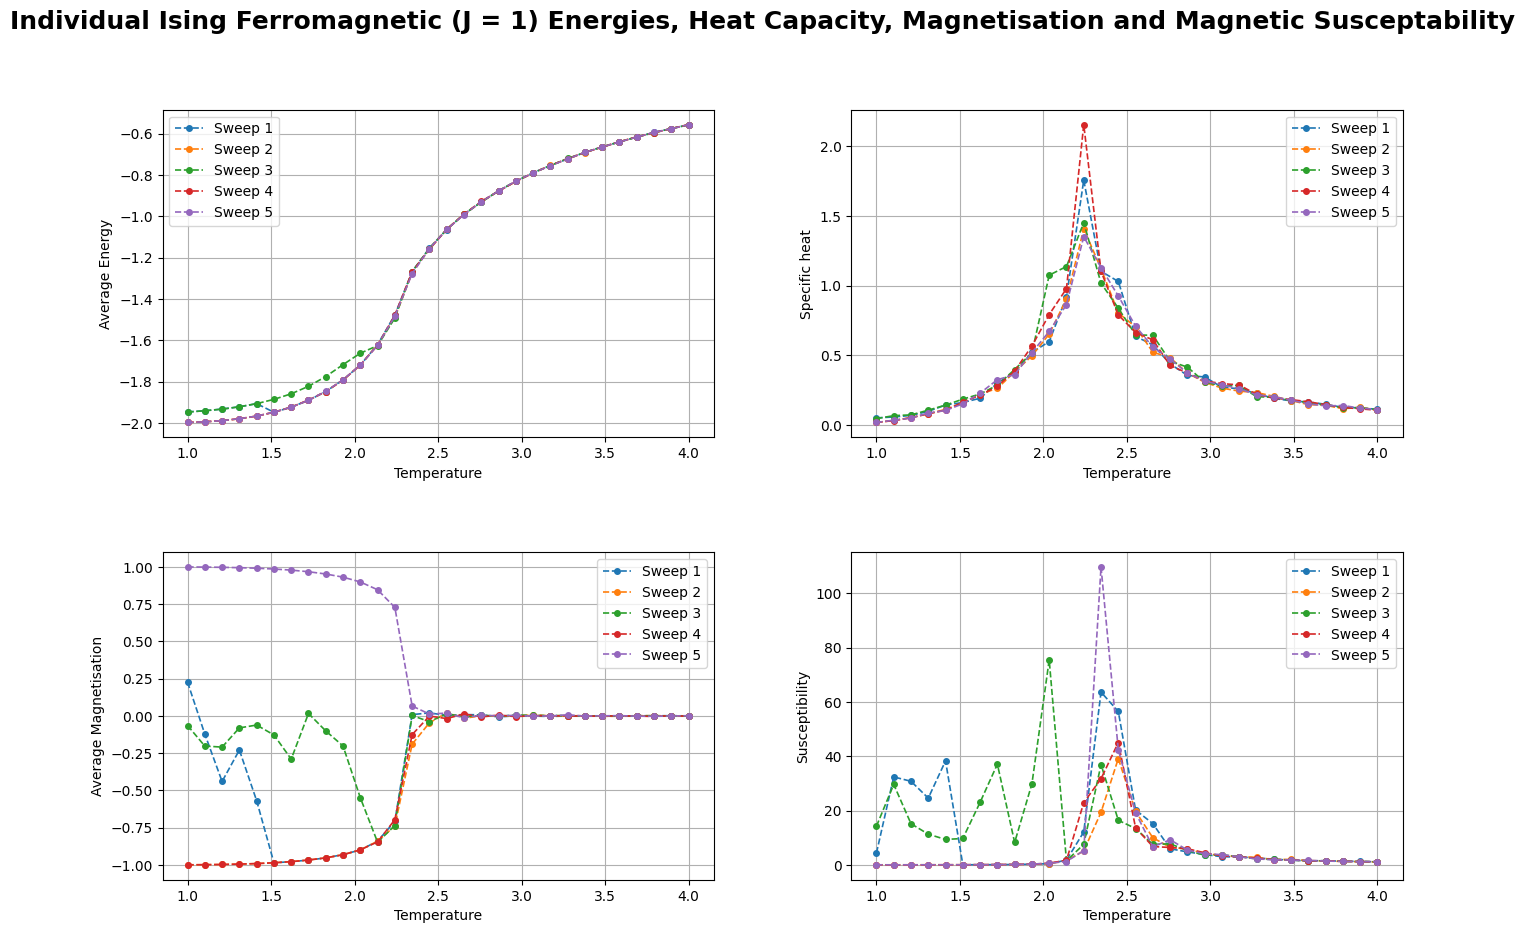

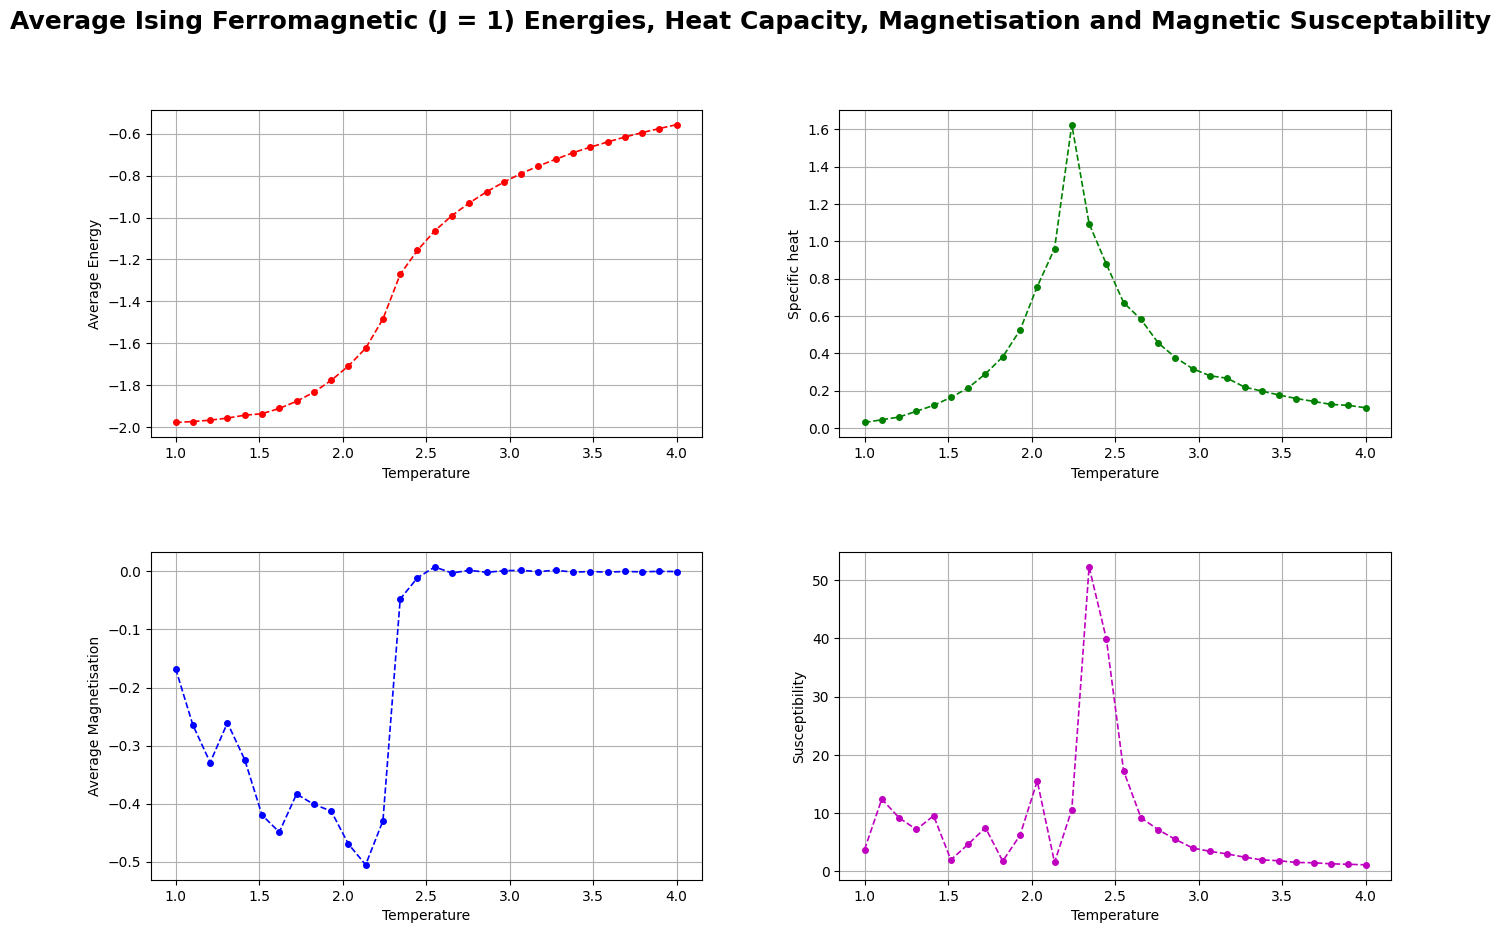

In [5]:
def RunAntiferromagneticSim(Points, Averaging, eqbmstart, neq, trials, N, T, L, J, title):
    """
    Runs the Monte Carlo Simualtion for many points over a range of temperatures, and plots the 
    Individual runs aswell as the average of the runs
    
    Parameters:
        Points - Number of Points to plot the Temperature Over
        Averaging - Number of Sweeps to Plot and Average Over
        eqbmstart - Number of Trials we equilibriate for
        neq - Number of Trials to run after Equilibriation
        trials - Number of Total Trials to run (eqbmstart + neq)
        N - Total Number of Spin Sites (L^2)
        T - Temperature of the System
        L - Number of Spin Sites 
        J - Ising Number, determining if System is AntiFerromagnetic or Magnetic
        title - The Title to use for the Super Plot
    """
    # Indexes : 0 : Energy, 1 : Specific Heat Capacity, 2 : Magnetisation, 3 : Spin Susceptiability
    Data = np.empty((Points, Averaging, 4), dtype=float)

    # Loop through the number of Times we Average
    for j in range(Averaging):
        
        # Create a Unique Spins Matrix for each run
        Spins = -1 + 2 * randint(2, size=(L, L))  # lxl matrix of spins (+/-1)
        
        # Run through all the Temperature Points
        for i in range(Points):
            Data[i, j] = RunMonteCarloTrials(Spins, eqbmstart, neq, trials, N, T[i], L, J)

    plotIsingResults(Data, T, f"Individual {title}")
    plotAverageIsingResults(Data, T, title)

# Define the Temperature
T = np.linspace(1, 4, Points)  # Temperature

# Simulation Runtime
eqbmstart = 2000  
neq = 1000  
trials = eqbmstart + neq

# Run Antiferromagnetic Simulation
J = -1
RunAntiferromagneticSim(Points, Averaging, eqbmstart, neq, trials, N, T, SpinSites, J, "Ising Antiferromagnetic (J = -1) Energies, Heat Capacity, Magnetisation and Magnetic Susceptability")

# Run Ferromagnetic Simulation
J = 1
RunAntiferromagneticSim(Points, Averaging, eqbmstart, neq, trials, N, T, SpinSites, J, "Ising Ferromagnetic (J = 1) Energies, Heat Capacity, Magnetisation and Magnetic Susceptability")

## Comments
-----
We can see when comparing Antiferromagnetic and Magnetic regimes that the Energy and Specific Heat Capacity are equivalent, but the Average Magnetization and the Systems Susceptibility are different.

In the Antiferromagnetic regime, the Average Magnetization hovers around 0, and the Susceptibility is near 0

Where as in the Ferromagnetic regime, the system is magnetized in the positive or negative state, which gets averaged to near 0.5 with fluctuations, but gradually goes to 0 after passing the Phase Transition Temperature. The susceptibility of the system is much higher than the Antiferromagnetic system, but peaks at the Phase Transition Temperature

# Question 2 : Equilibrium Analysis
-----
Investigate whether 2000 sweeps are sufficient to reach equilibrium.
 Steps:
 1. Choose temperatures below, near, and above the phase transition (e.g. $T=1.5, 2.3, 3.0$).
 2. Track energy and magnetization as functions of the number of sweeps.
 3. Plot $E$ and $M$ vs. sweeps to see when the system stabilizes.
 4. Comment on whether 2000 sweeps are sufficient



## Modified Function Definition
-----
In this section I modify the RunMonteCarloTrials function so that it returns the Array of Energy and Magnetisation without summing and averaging it

In [6]:
@njit
def RunMonteCarloTrials(Spins, eqbmstart, neq, trials, N, T, L, J):
    """Runs the Metropolis Monte Carlo Trials over the course of eqbmstart + neq steps
    
    Parameters:
        Spins - 2D LxL Matrix of the Spin States (Modified in Place)
        eqbmstart - Number of Trials we equilibriate for
        neq - Number of Trials to run after Equilibriation
        N - Total Number of Spin Sites (L^2)
        T - Temperature of the System
        L - Number of Spin Sites 
        J - Ising Number, determining if System is AntiFerromagnetic or Magnetic
        
    Returns:
        E - Energy over the course of the MonteCarlo Simulation
        M - Magnetisation over the course of the MonteCarlo Simulation
    """
    M = np.zeros(neq)
    E = np.zeros(neq)

    # Perform Monte-Carlo trials -----------------------------------------------
    for trial in range(trials):
        indx = permutation(N)
        rowsub, colsub = ind2sub(indx, L)
        Energy = Metropolis(rowsub, colsub, trial, Spins, eqbmstart, N, T, L, J)
        if trial >= eqbmstart:
            t = trial - eqbmstart
            E[t] = Energy
            M[t] = np.sum(Spins)
            
    # Results--------------------------------------
    # Modified-------------------------------------
    Eav = E / N
    Mav = M / N
    # End of Modification--------------------------
            
    return [Eav, Mav]

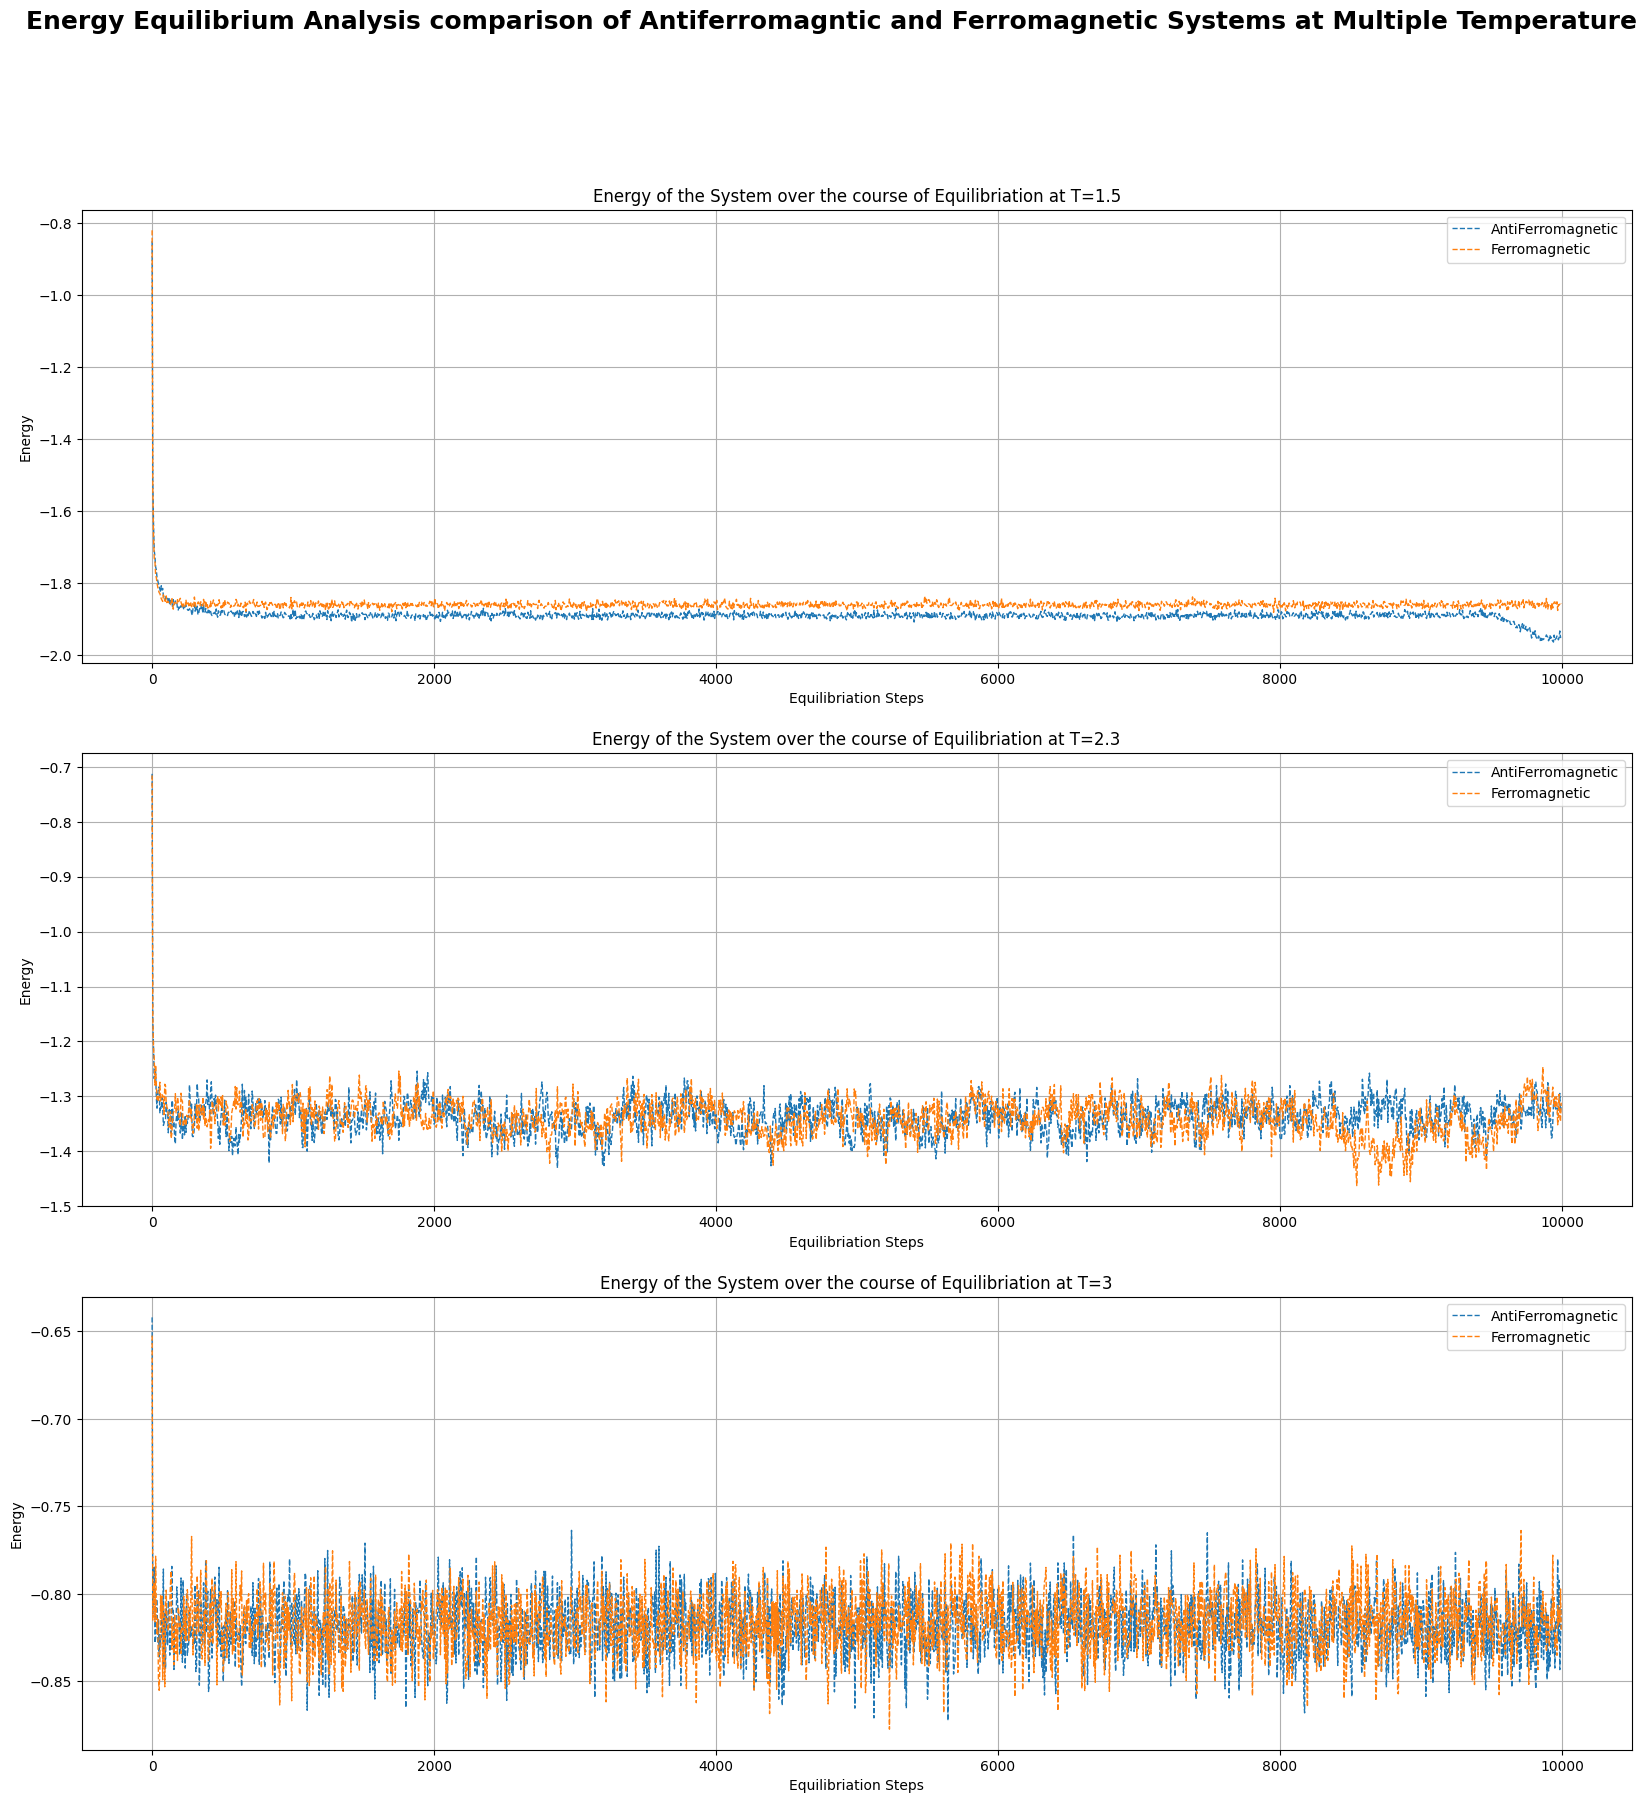

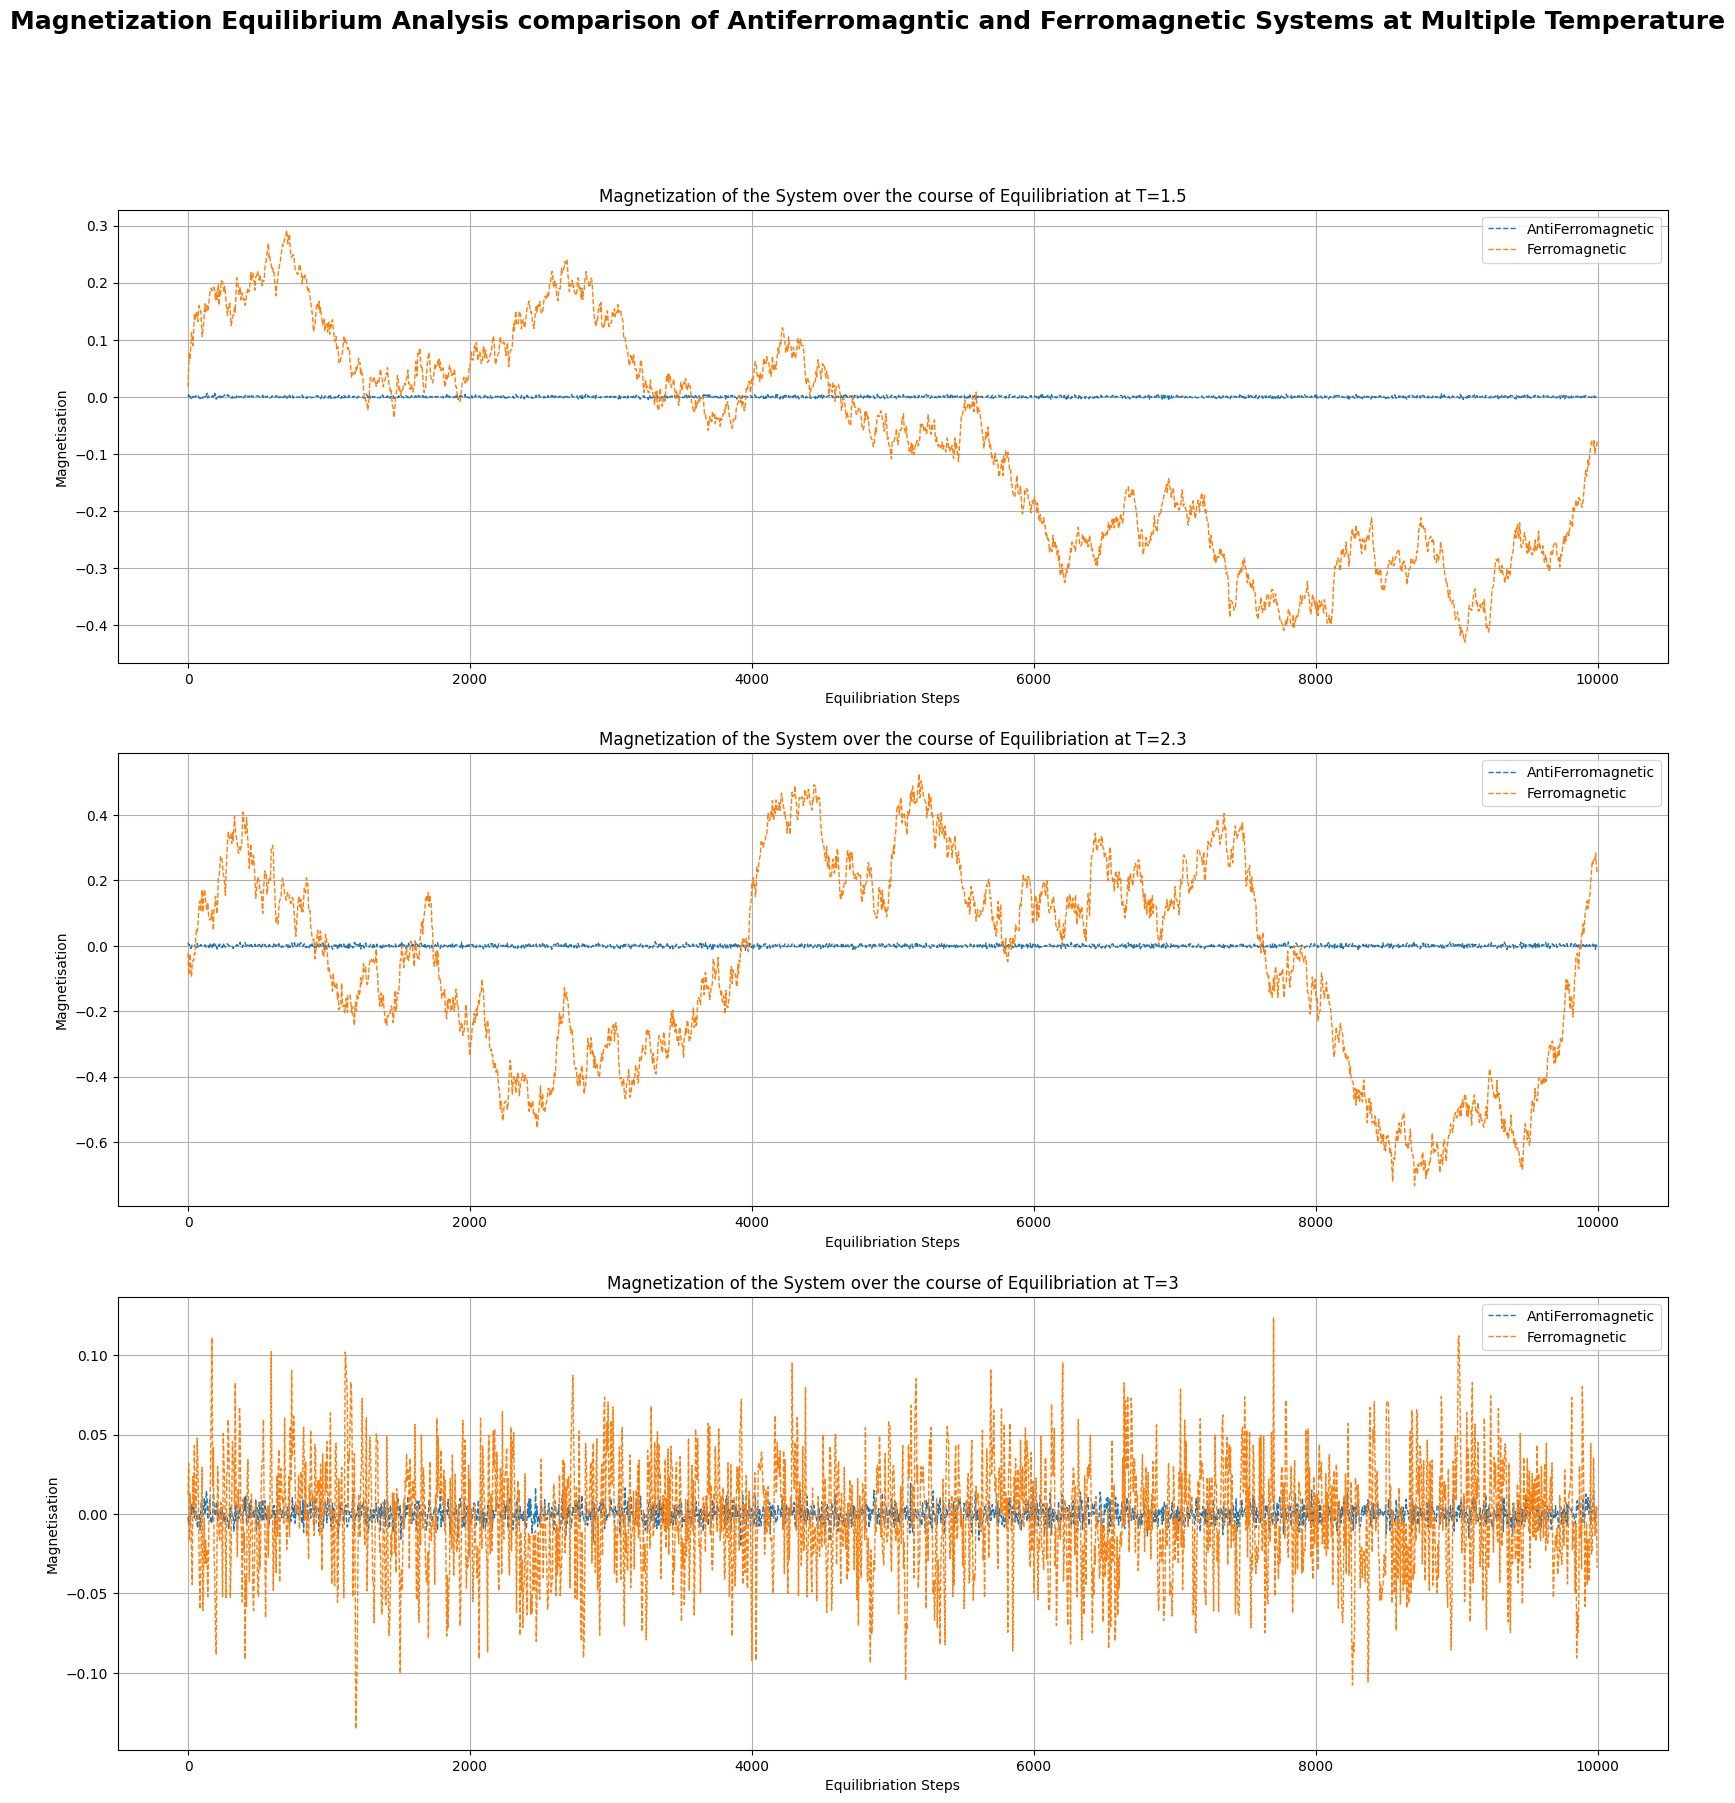

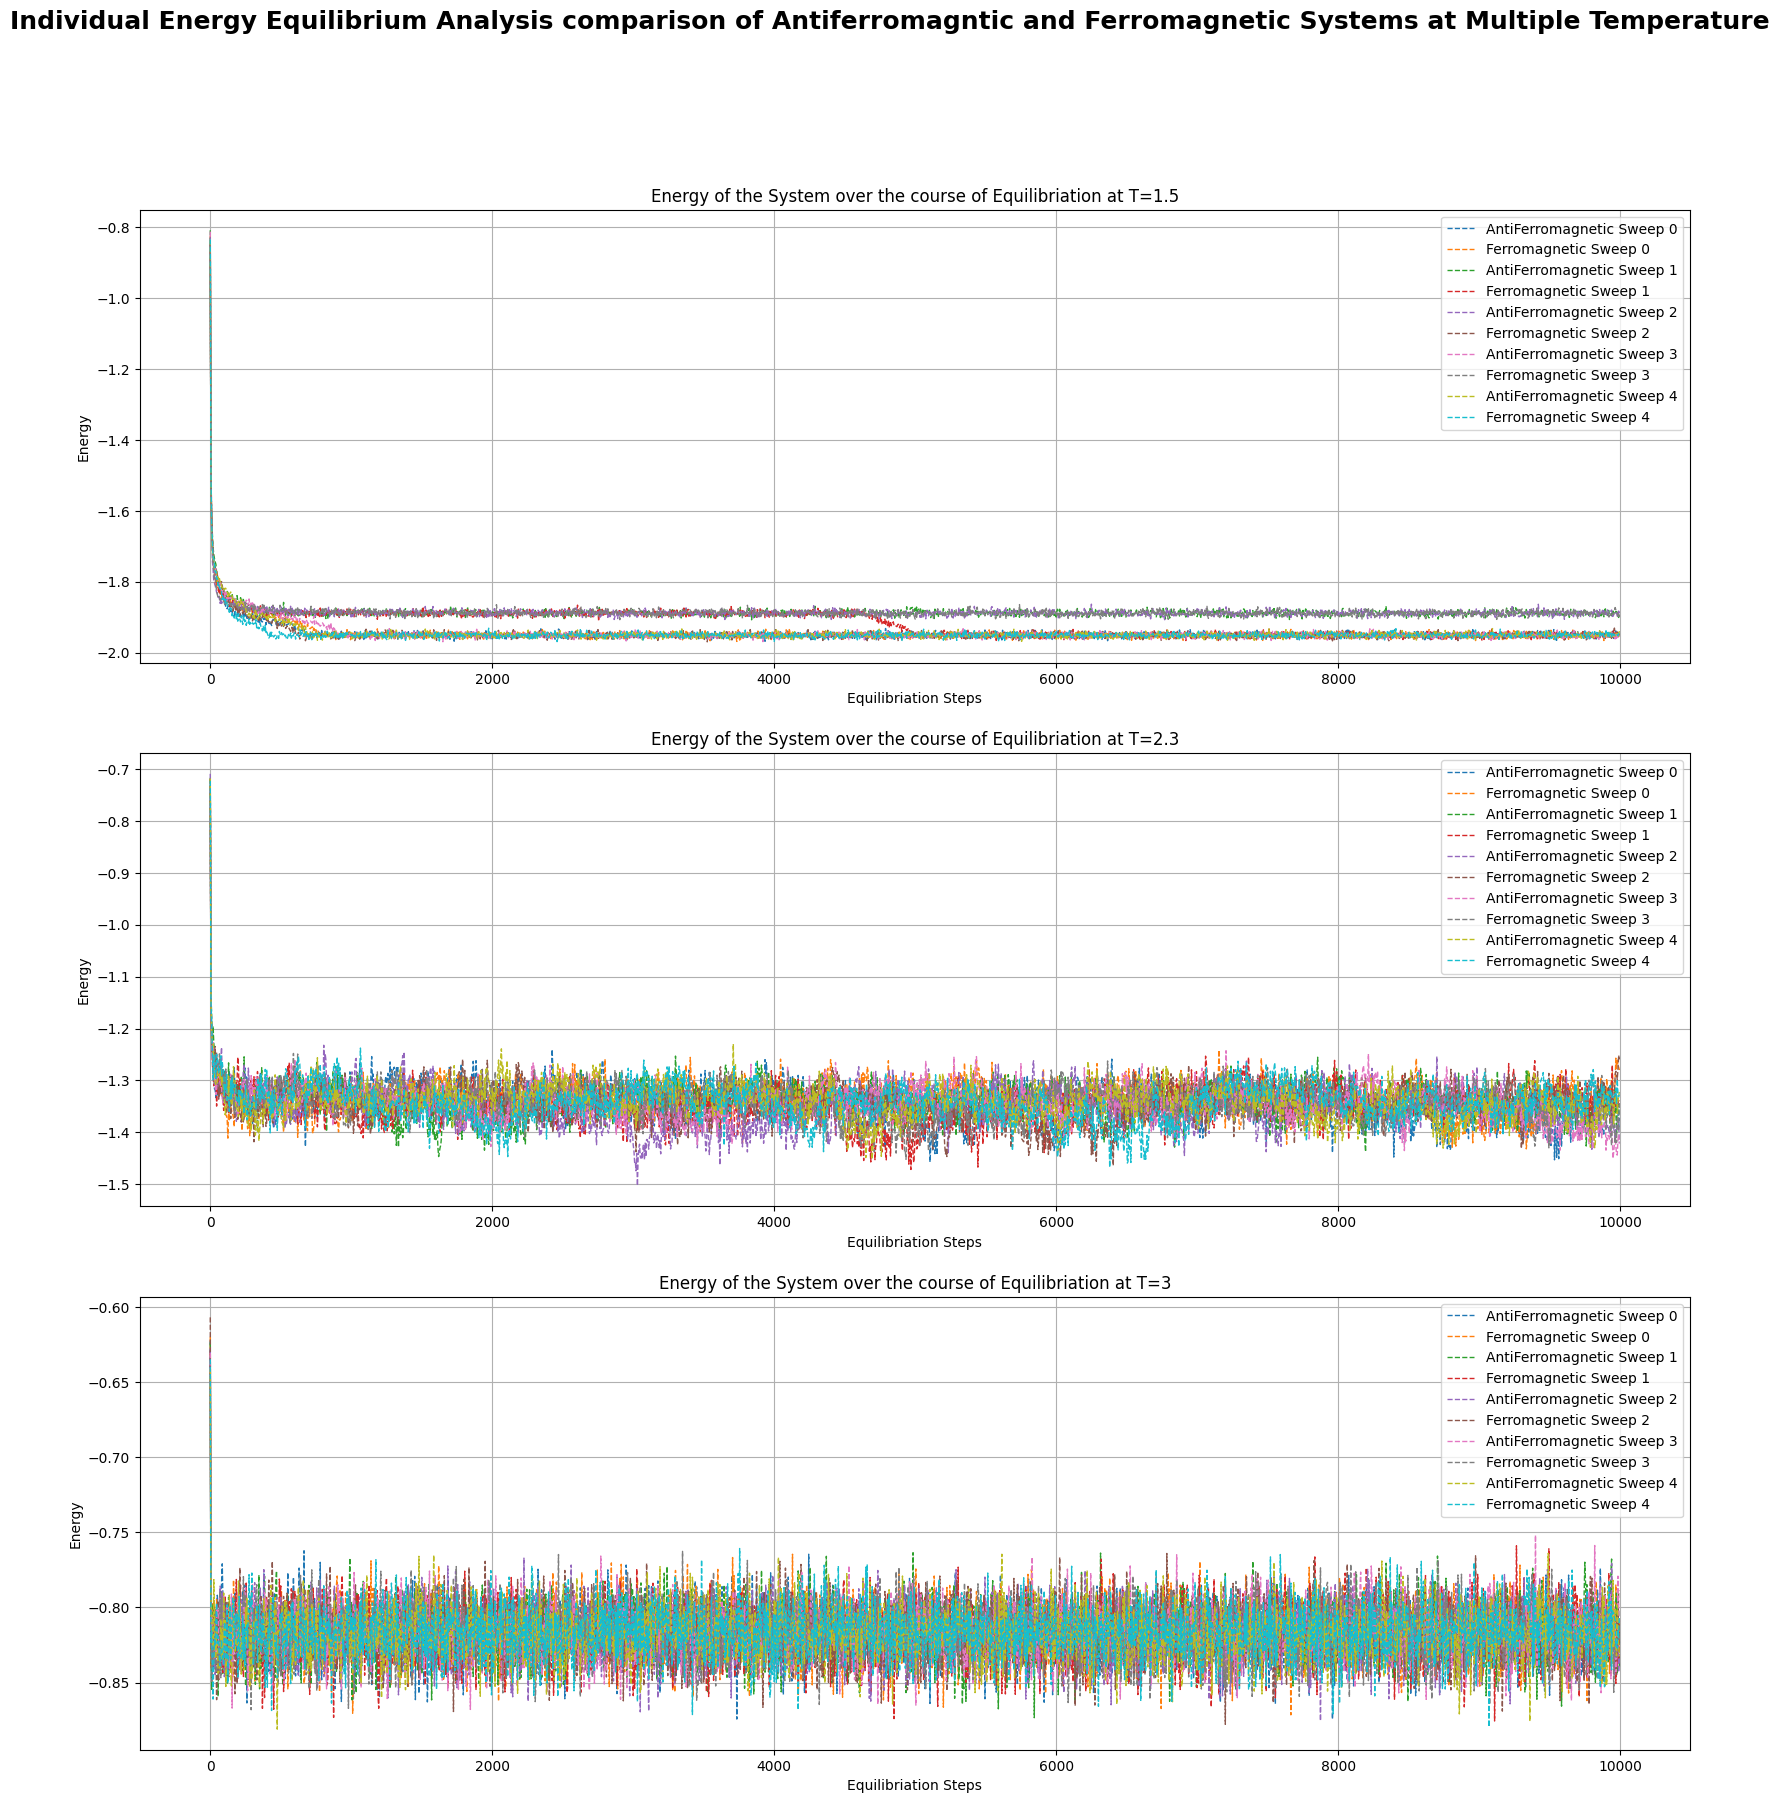

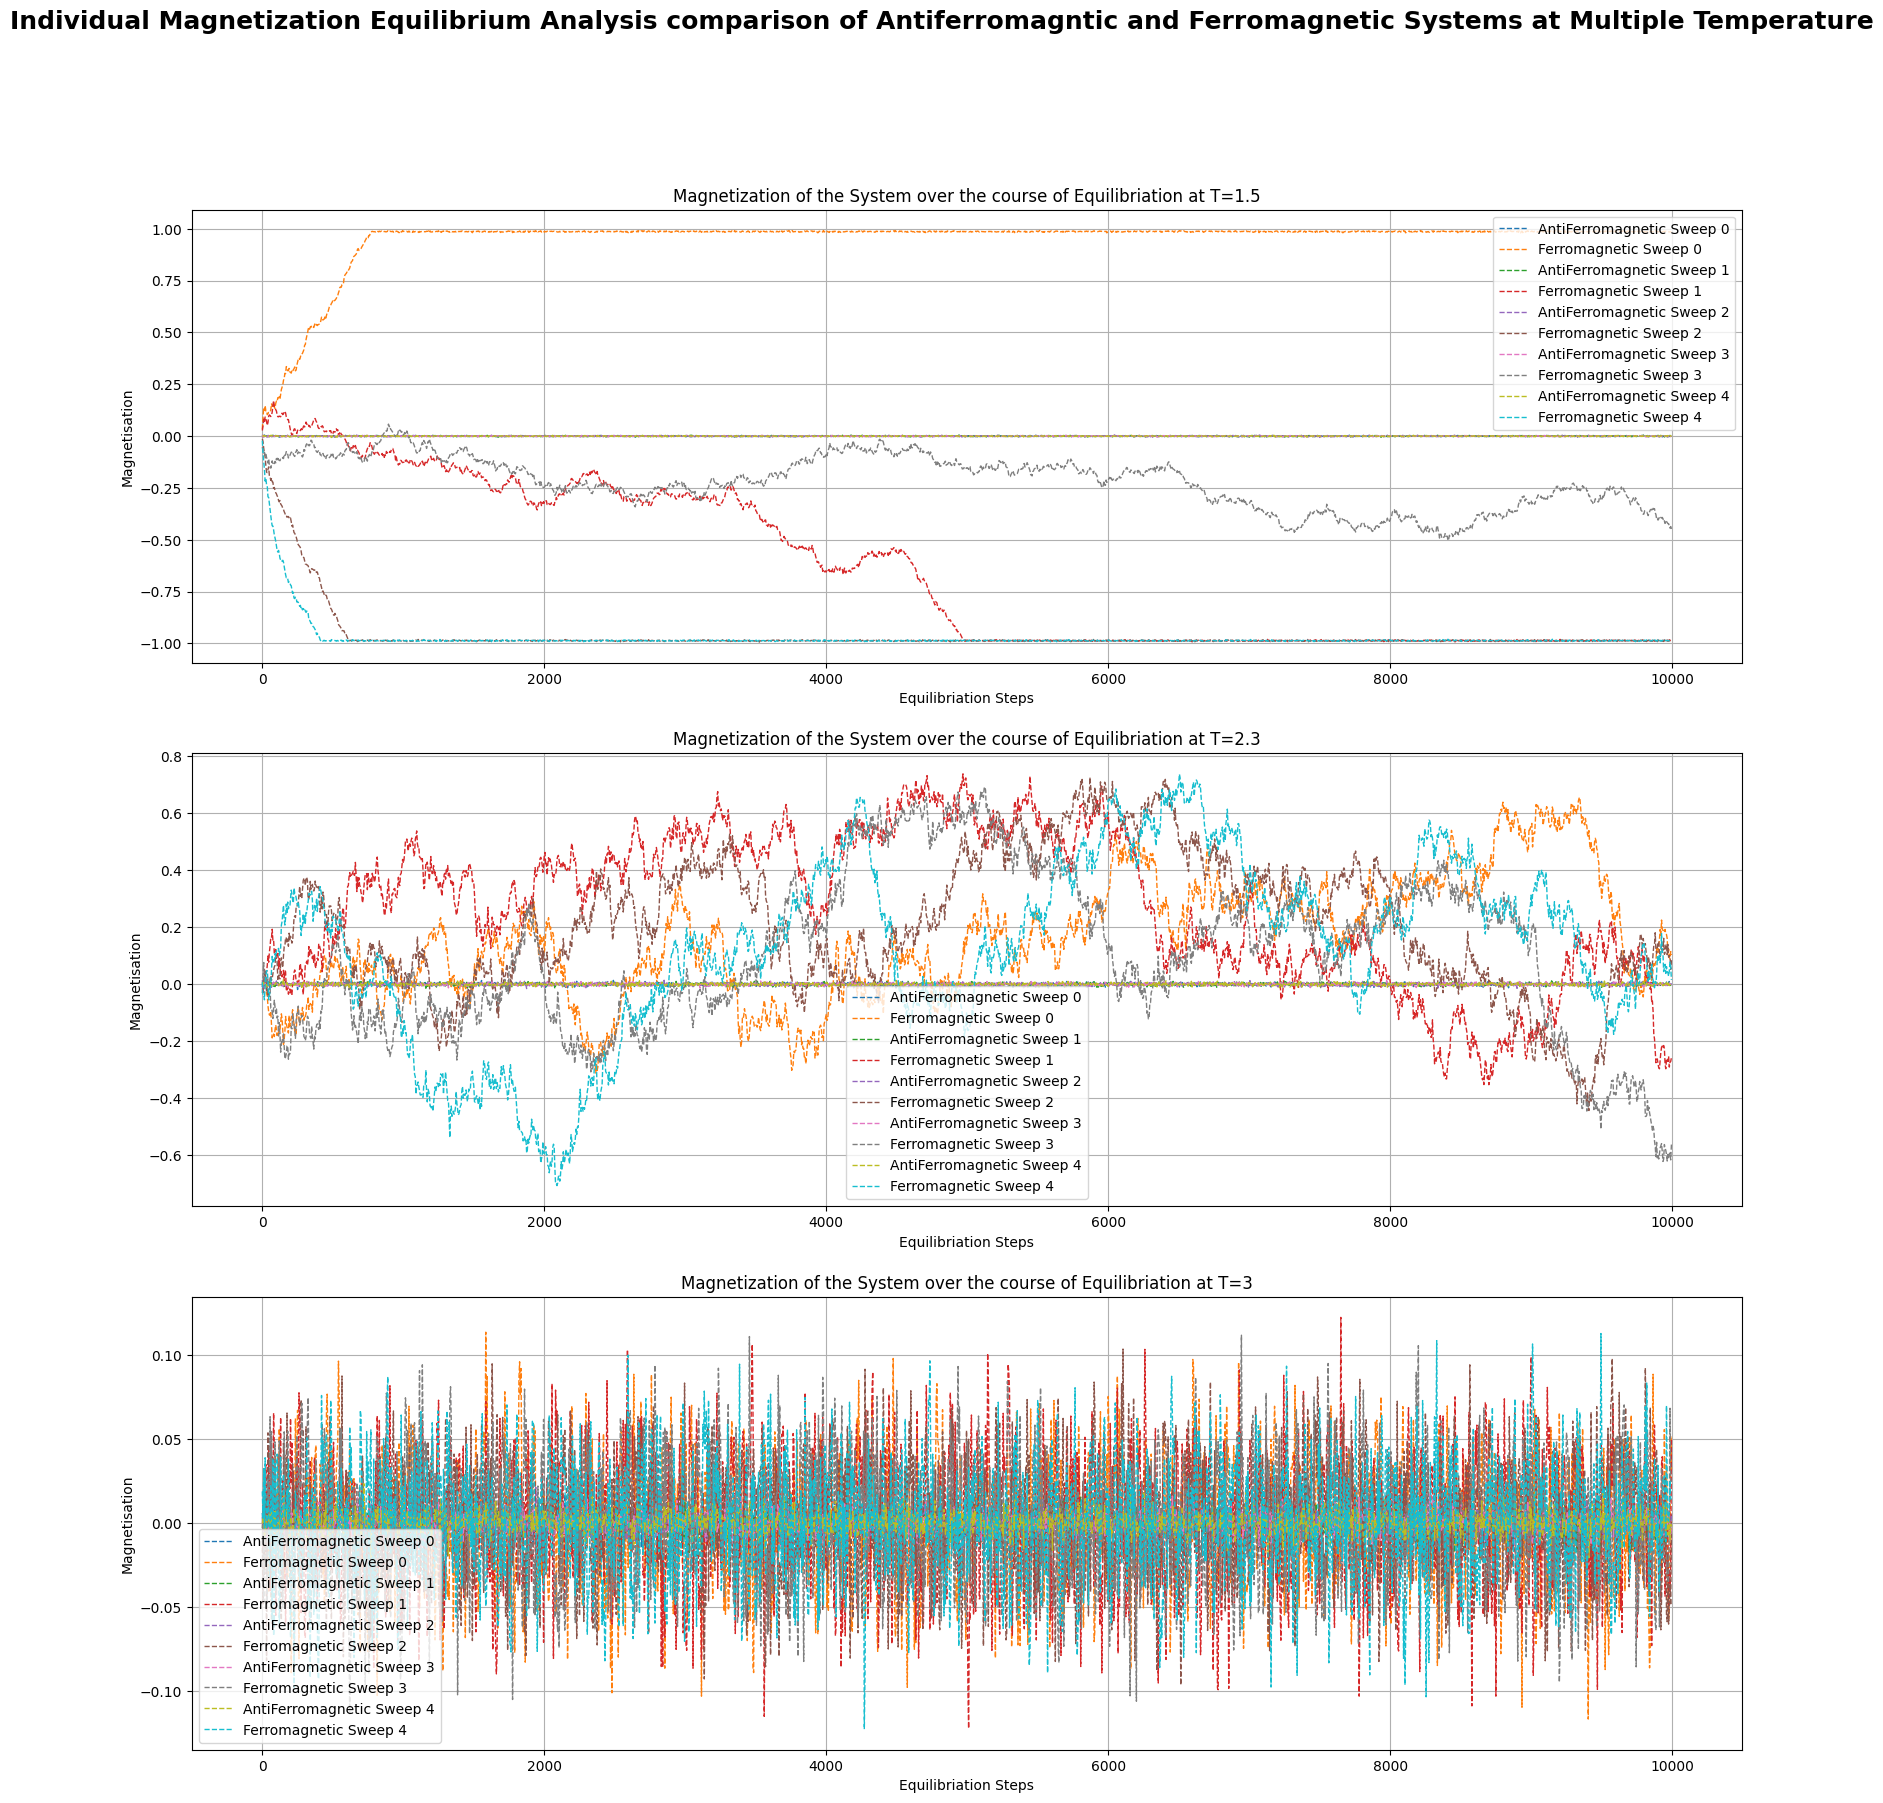

In [7]:
def RunEquilibriumSim(Averaging, eqbmstart, neq, trials, N, T, L, title):
    """
    Runs instances of the Monte Carlo Simulation and plots the array of Energy and Magnetization
    Plots it a single time, then plots it a few more times to observe the fluctuations that 
    Occur over the course of different simulations
    
    Parameters:
        Averaging - Number of Sweeps to Plot and Average Over
        eqbmstart - Number of Trials we equilibriate for
        neq - Number of Trials to run after Equilibriation
        trials - Number of Total Trials to run (eqbmstart + neq)
        N - Total Number of Spin Sites (L^2)
        T - Temperature of the System
        L - Number of Spin Sites 
        title - The Title to use for the Super Plot
    """
    # Indexes : 0 : Energy, 1 : Magnetisation
    DataAntiferro = np.empty((len(T), 2, neq), dtype=float)
    DataFerro = np.empty((len(T), 2, neq), dtype=float)

    # Loop through all the Temperatures
    for k in range(len(T)):
        Spins = -1 + 2 * randint(2, size=(L, L))  # lxl matrix of spins (+/-1)
        DataAntiferro[k] = RunMonteCarloTrials(Spins, eqbmstart, neq, trials, N, T[k], L, J=-1)
        
        Spins = -1 + 2 * randint(2, size=(L, L))  # lxl matrix of spins (+/-1)
        DataFerro[k] = RunMonteCarloTrials(Spins, eqbmstart, neq, trials, N, T[k], L, J=1)

    plotEquilibriumAnalysis(DataAntiferro, DataFerro, neq, T, title)
    
    # Indexes : 0 : Energy, 1 : Magnetisation
    DataAntiferro = np.empty((len(T), Averaging, 2, neq), dtype=float)
    DataFerro = np.empty((len(T), Averaging, 2, neq), dtype=float)
    
    # Plot over the number of runs to Average and over all Temps
    for i in range(Averaging):
        for k in range(len(T)):
            Spins = -1 + 2 * randint(2, size=(L, L))  # lxl matrix of spins (+/-1)
            DataAntiferro[k, i] = RunMonteCarloTrials(Spins, eqbmstart, neq, trials, N, T[k], L, -1)
            
            Spins = -1 + 2 * randint(2, size=(L, L))  # lxl matrix of spins (+/-1)
            DataFerro[k, i] = RunMonteCarloTrials(Spins, eqbmstart, neq, trials, N, T[k], L, 1)
    
    plotIndividualEquilibriumAnalysis(DataAntiferro, DataFerro, neq, T, title)

# Define the Temperature
T = [1.5, 2.3, 3]

# Simulation Runtime  
eqbmstart = 0  
neq = 10000
trials = eqbmstart + neq

# Run Antiferromagnetic Simulation
RunEquilibriumSim(Averaging, eqbmstart, neq, trials, N, T, SpinSites, "Equilibrium Analysis comparison of Antiferromagntic and Ferromagnetic Systems at Multiple Temperature")

## Is 2000 Steps enough to converge?
-----
Based on the Energy graphs, 2000 steps are enough for the Systems Energy to converge in the both the Ferromagnetic and AntiFerromagnetic regimes

The Magnetization is a little tricker on the other hand. In the case of the AntiFerromagnetic regime, 2000 steps is more than enough for it to converge, but in the case of the FerroMagnetic Regime, it will sometimes converge before 2000 steps, while other times it will fluctuate during the entire simulation. In the case where the system ends up converging, 2000 steps is more than enough. In the case where the magnetization fluctuates during the entire simulation it would not be considered enough. This phenomenon only occurs below the Phase Transition Temperature, as shown in the later multiple individual runs

Once we reach a high enough temperature the Ferromagnetic regime does end up converging, by fluctuating around 0, but it has a much higher level of noise compared to the AntiFerromagnetic Regime

The second group of graphs show the inconsistincies that may sometimes occur where the Magnetization will flip flop from -1 to 1 or fluctuate between for the T = 1.5 cases, they also show that sometimes, the system equilibriates, but has a second equilibriation drop around 9000 steps

# Question 3 : External Magnetic Field 
-----
Modify the provided code to include a magnetic field term:

$$E=-J\sum_{\langle i, j \rangle} s_i\cdot s_j - g\cdot \mu_B\cdot H \sum_i s_i$$

With $g\cdot \mu_B\cdot H = 1$

Tasks:
- Implement this in your code.
- Run simulations at various temperatures.
- Compute and plot:
    - Energy 
    - Magnetization 
    - Heat capacity 
    - Susceptibility 
- Compare with the zero-field case and discuss the effect of .

## Implementation
-----
In order to properly answer this question we need to redefine the implementation of the Metroplis Algorithm and the RunMonteCarloTrials function, they are shown below :

In [8]:
# Metropolis algorithm function --------------------------------------------
@njit
def Metropolis(rowsub, colsub, trial, Spins, eqbmstart, N, T, L, J, h):
    """Runs the Metropolis Algorithm for trial Modifications for a Systems Spin States within a External Magnetic Field
    
    Parameters:
        rowsub - Row Index
        colsub - Column Index
        trial - Trial Number Index
        Spins - 2D LxL Matrix of the Spin States (Modified in Place)
        eqbmstart - Number of Trials we equilibriate for
        N - Total Number of Spin Sites (L^2)
        T - Temperature of the System
        L - Number of Spin Sites 
        J - Ising Number, determining if System is AntiFerromagnetic or Magnetic
        h - Strength of the External Magnetic Field
        
    Returns:
        Energy - Energy of the System
    """
    inverseT = 1/T
    Energy = 0.0
    for counter in range(N):  # for every spin site
        r = int(rowsub[counter])

        lo = r - 1
        if lo < 0:
            lo = L - 1

        hi = r + 1
        if hi > L - 1:
            hi = 0

        c = int(colsub[counter])

        lf = c - 1
        if lf < 0:
            lf = L - 1

        rt = c + 1
        if rt > L - 1:
            rt = 0

        # Sum neighbouring spins
        SS = Spins[lo, c] + Spins[hi, c] + Spins[r, lf] + Spins[r, rt]
        
        # Energy change if flipped
        DeltaE = 2 * J * SS * Spins[r, c] - 2 * h * Spins[r, c] # Added : 2 * h * Spins[r, c]
        
        # Metropolis
        if DeltaE < 0 or rand() < np.exp(-DeltaE * inverseT):
            Spins[r, c] = -Spins[r, c]
        if trial >= eqbmstart:
            Energy = Energy - 0.5 * J * SS * Spins[r, c] - h * Spins[r, c] # Added : - h * Spins[r, c]
    return Energy

@njit
def RunMonteCarloTrials(Spins, eqbmstart, neq, trials, N, T, L, J, h):
    """Runs the Metropolis Monte Carlo Trials over the course of eqbmstart + neq steps within a External Magnetic Field
    
    Parameters:
        Spins - 2D LxL Matrix of the Spin States (Modified in Place)
        eqbmstart - Number of Trials we equilibriate for
        neq - Number of Trials to run after Equilibriation
        N - Total Number of Spin Sites (L^2)
        T - Temperature of the System
        L - Number of Spin Sites 
        J - Ising Number, determining if System is AntiFerromagnetic or Magnetic
        h - Strength of the External Magnetic Field
        
    Returns:
        Eav - Average Energy of the MonteCarlo Simulation
        Cv - Specific Heat Capacity of the MonteCarlo Simulation
        Mav - Average Magnetization of the MonteCarlo Simulation
        Chi - Susceptability of the MonteCarlo Simulation
    """
    M = np.zeros(neq)
    E = np.zeros(neq)

    # Perform Monte-Carlo trials -----------------------------------------------
    for trial in range(trials):
        indx = permutation(N)
        rowsub, colsub = ind2sub(indx, L)
        Energy = Metropolis(rowsub, colsub, trial, Spins, eqbmstart, N, T, L, J, h)
        if trial >= eqbmstart:
            t = trial - eqbmstart
            E[t] = Energy
            M[t] = np.sum(Spins)
            
    # Results -------------------------------------------------------------------
    Eav = np.mean(E) / N
    Cv = (np.var(E) / T**2) / N
    Mav = np.mean(M) / N
    Chi = (np.var(M) / T) / N
    
    return [Eav, Cv, Mav, Chi]

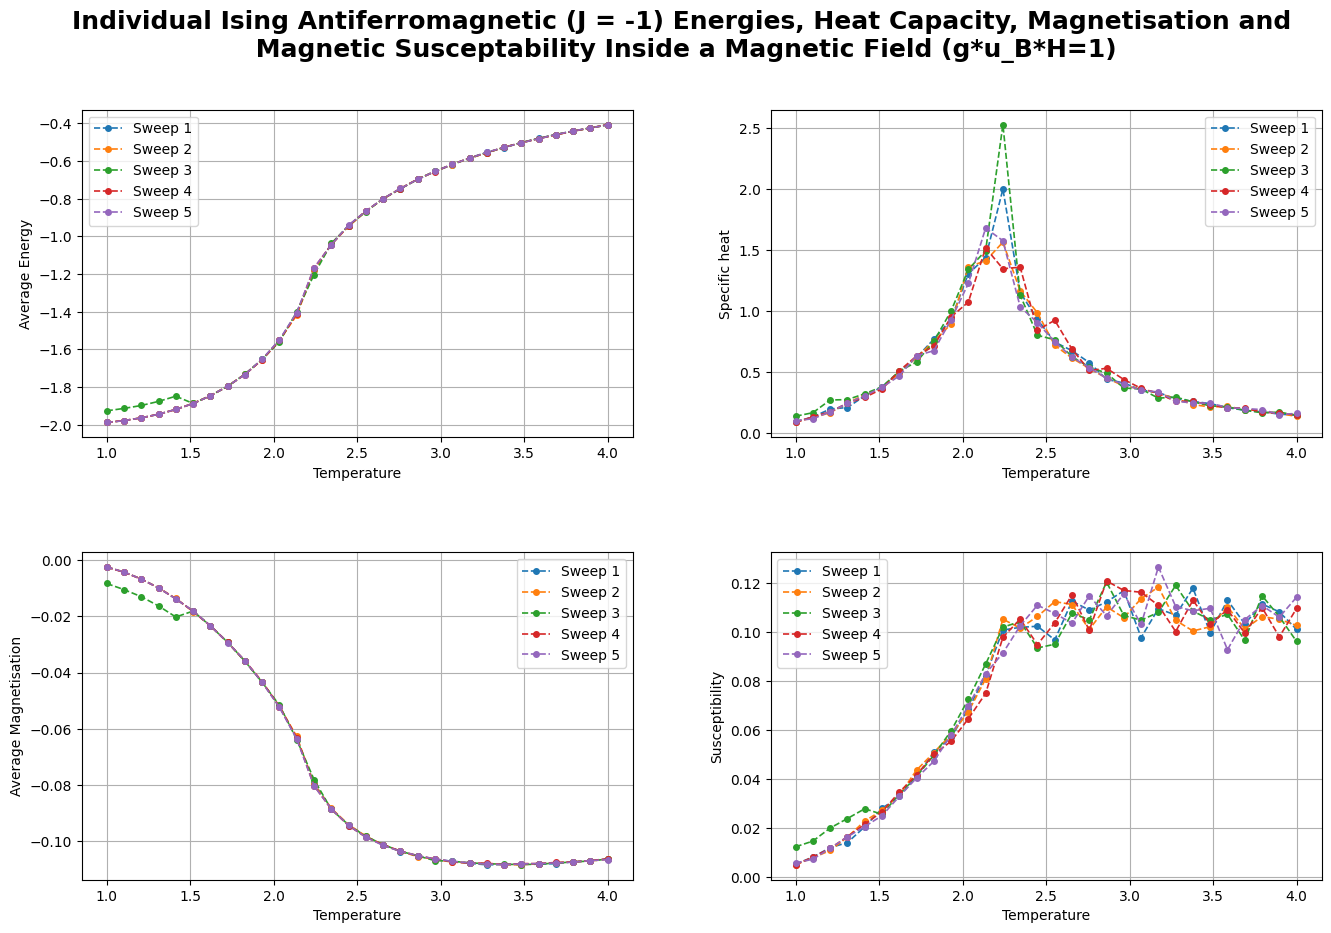

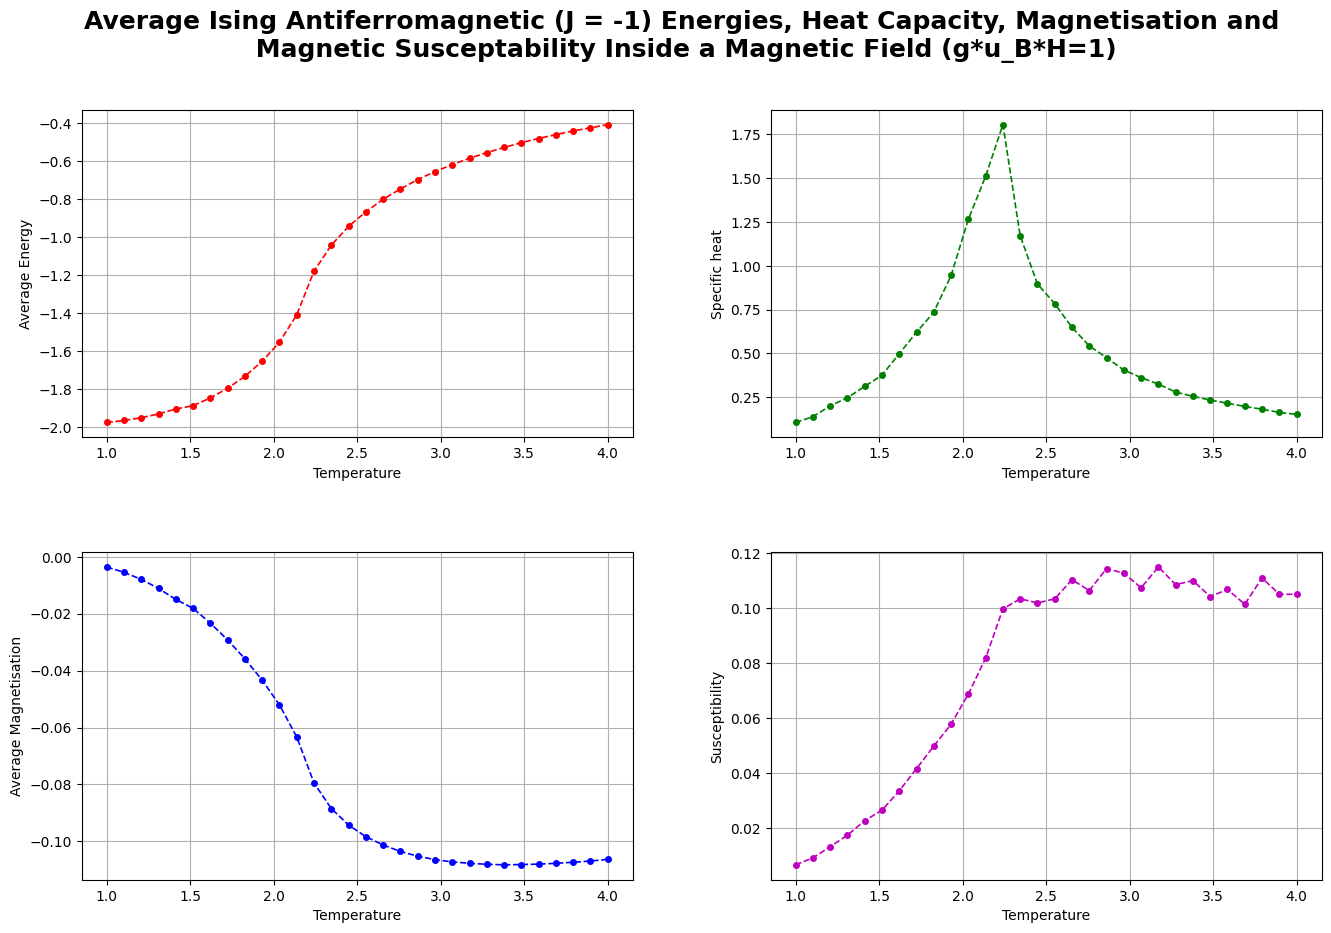

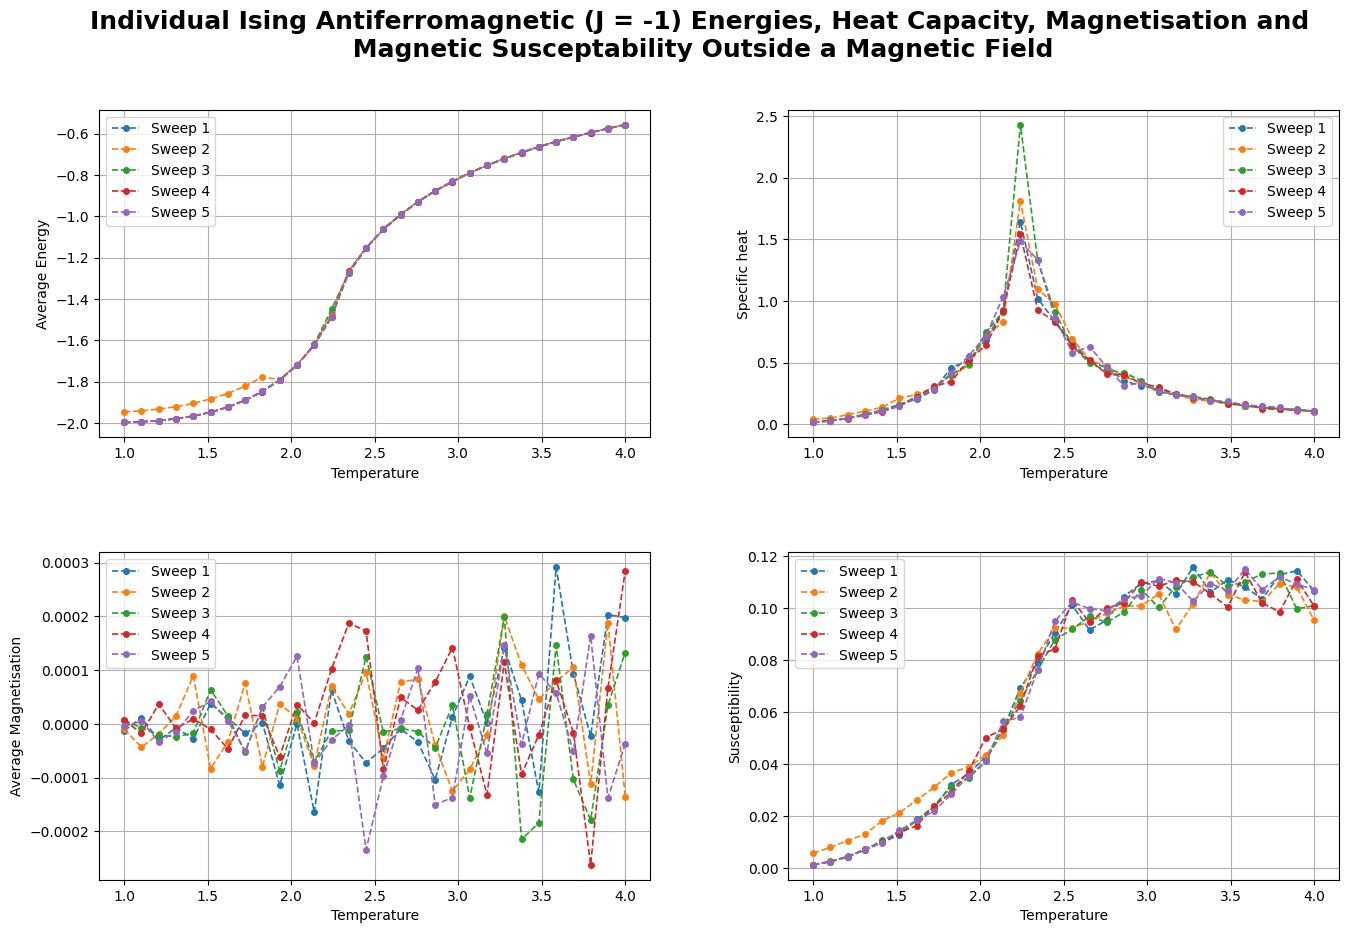

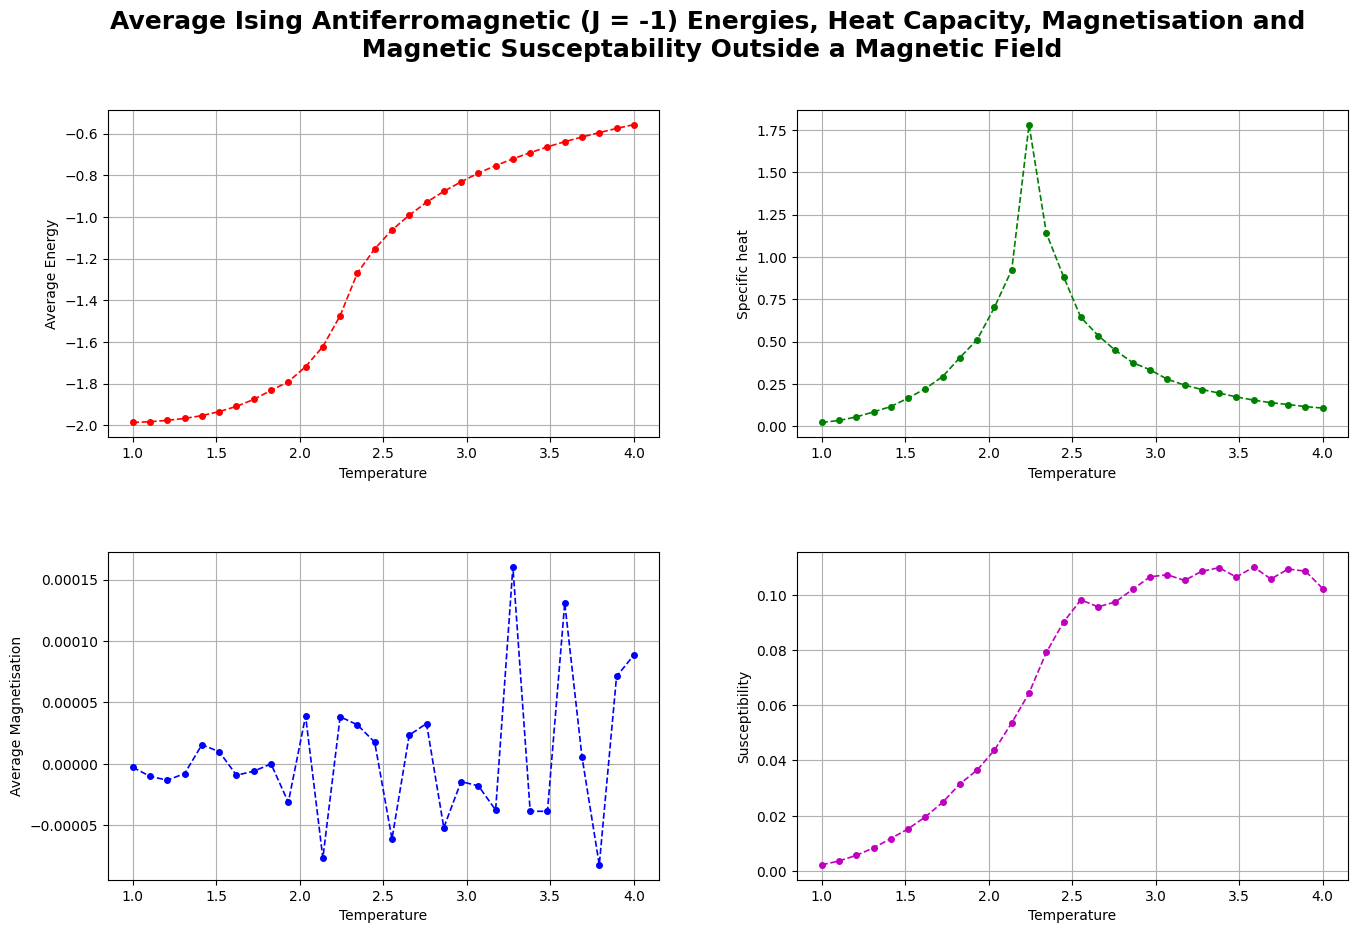

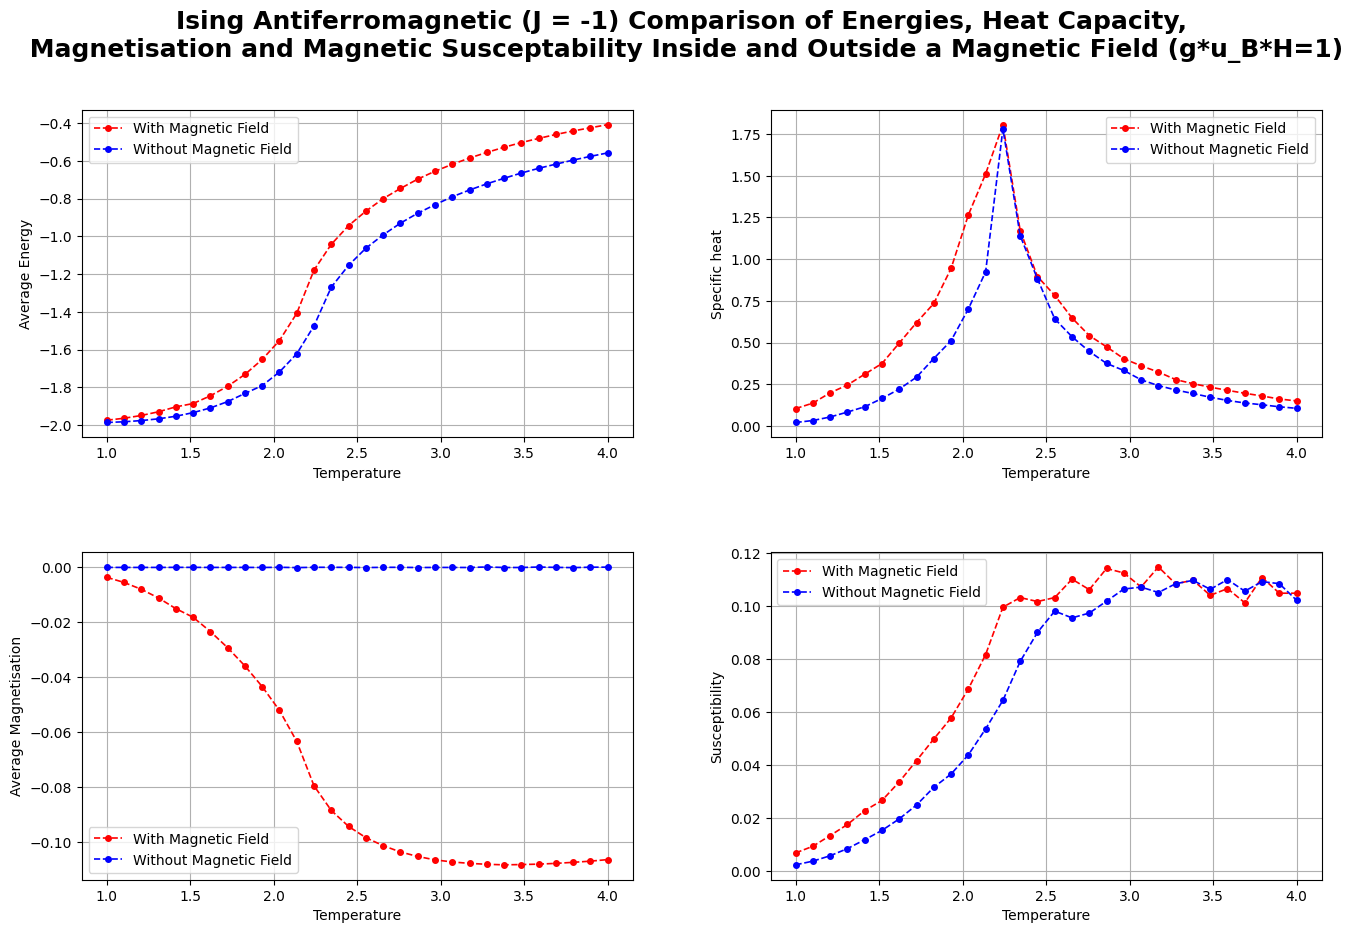

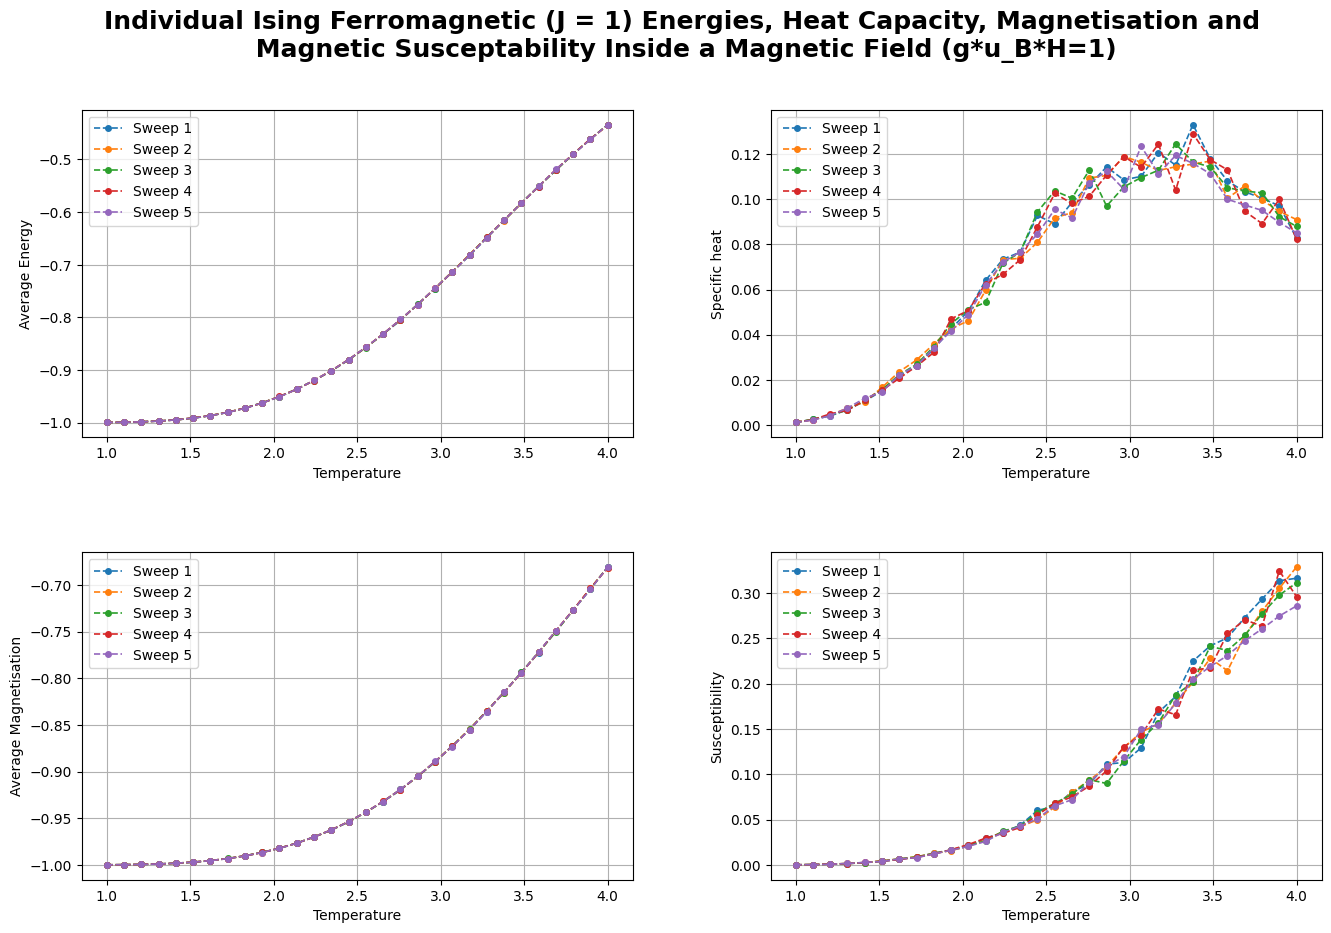

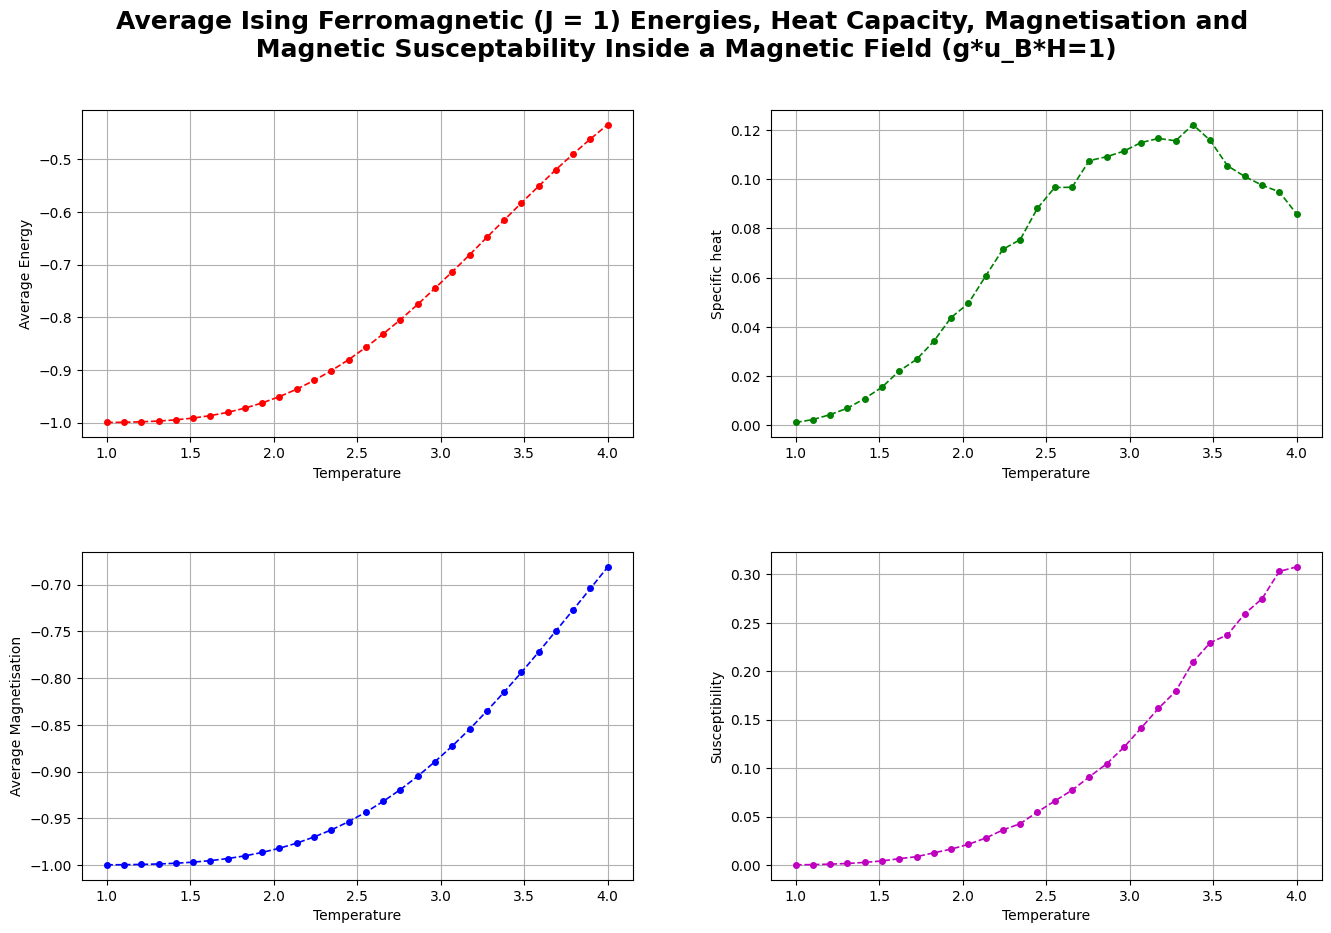

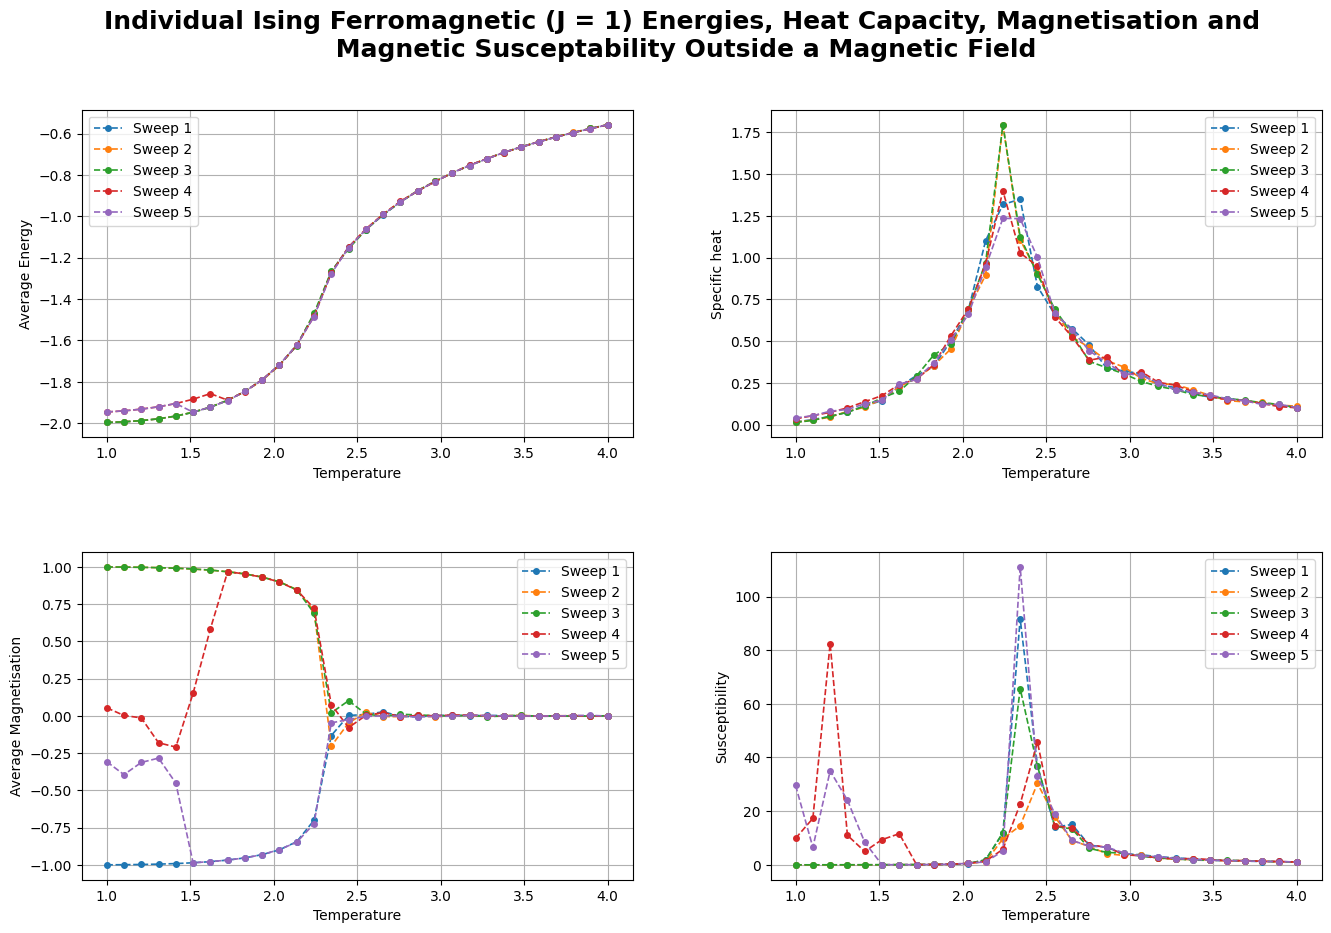

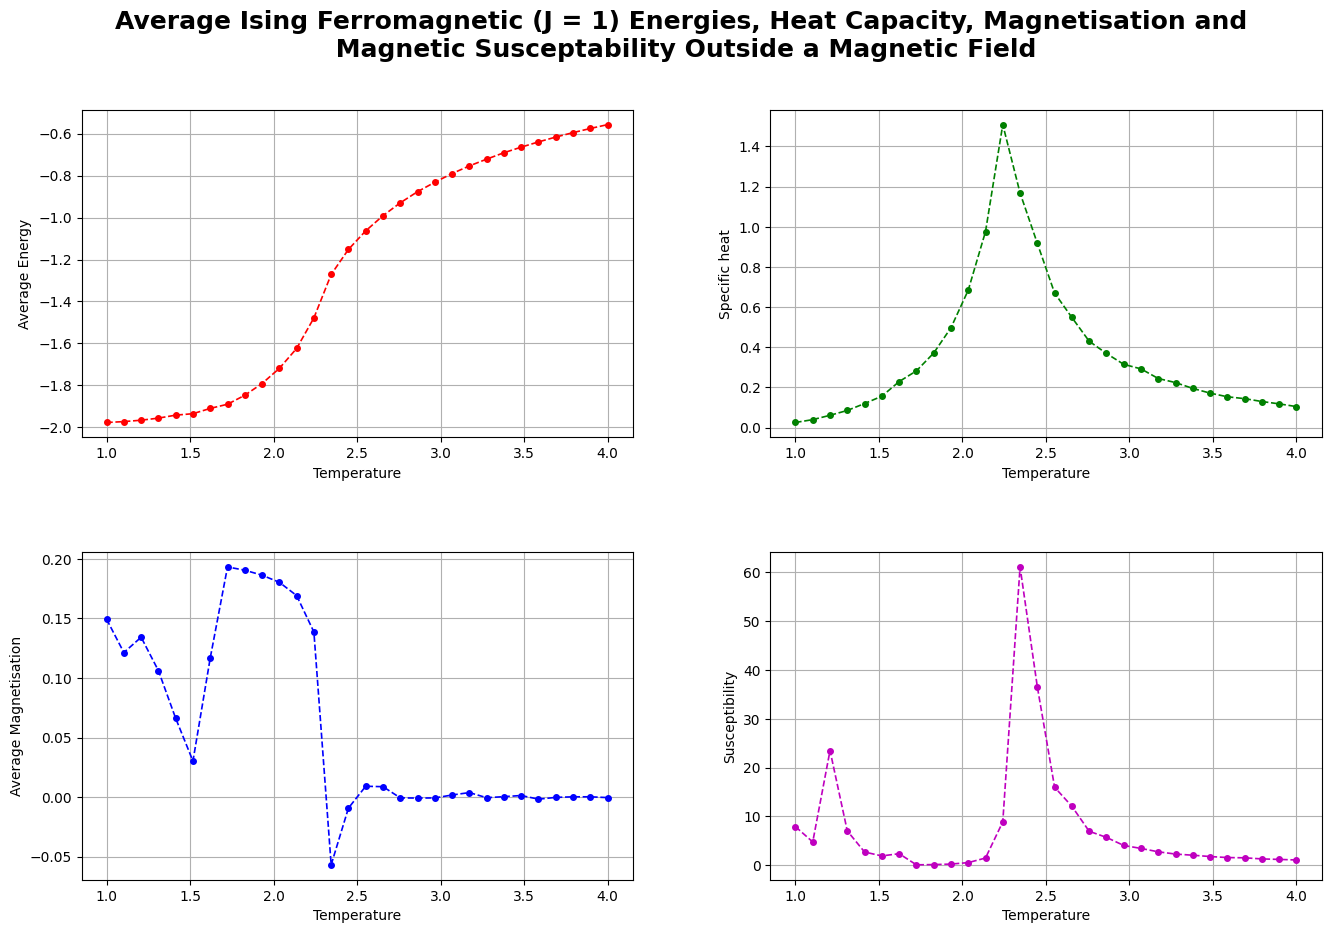

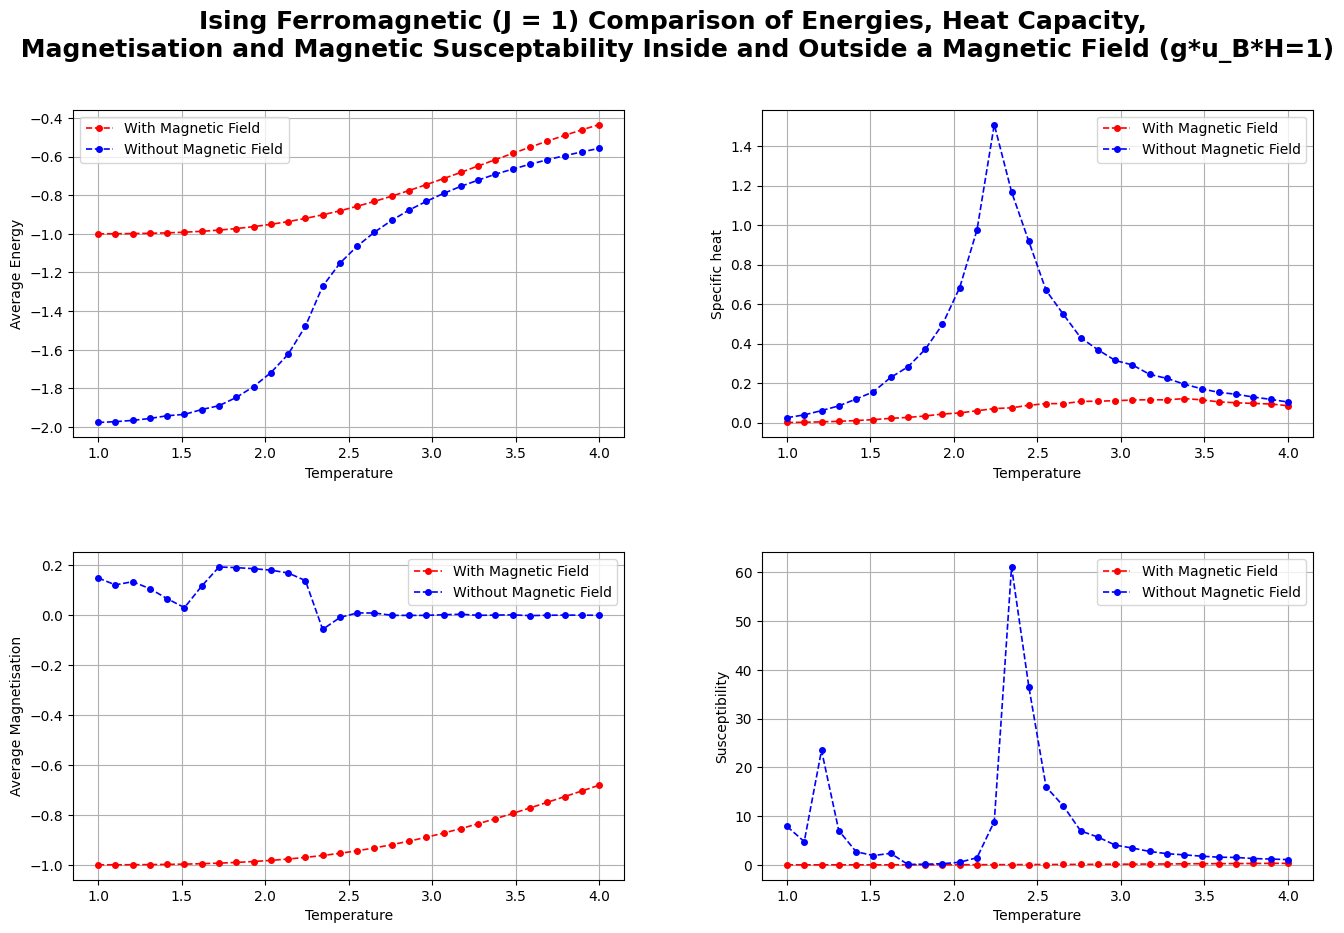

In [13]:
def RunMagneticFieldSim(Points, Averaging, eqbmstart, neq, trials, N, T, L, J, title):
    """
    Runs the Monte Carlo Simualtion for many points over a range of temperatures, and plots the 
    Individual runs aswell as the average of the runs, then one last plot to directly compare
    the Systems behavior under a External Magnetic Field and without one
    
    Parameters:
        Points - Number of Points to plot the Temperature Over
        Averaging - Number of Sweeps to Plot and Average Over
        eqbmstart - Number of Trials we equilibriate for
        neq - Number of Trials to run after Equilibriation
        trials - Number of Total Trials to run (eqbmstart + neq)
        N - Total Number of Spin Sites (L^2)
        T - Temperature of the System
        L - Number of Spin Sites 
        J - Ising Number, determining if System is AntiFerromagnetic or Magnetic
        title - The Title to use for the Super Plot
    """
    # Indexes : 0 : Energy, 1 : Specific Heat Capacity, 2 : Magnetisation, 3 : Spin Susceptiability
    DataMagneticField = np.empty((Points, Averaging,  4), dtype=float)
    DataNoMagneticField = np.empty((Points, Averaging, 4), dtype=float)

    # Loop through the number of Times we Average
    for j in range(Averaging):
        
        # Create a Unique Spins Matrix for each run
        SpinsMagnet = -1 + 2 * randint(2, size=(L, L))  # lxl matrix of spins (+/-1)
        SpinsNoMagnet = -1 + 2 * randint(2, size=(L, L))  # lxl matrix of spins (+/-1)
        
        # Run through all the Temperature Points
        for i in range(Points):
            DataMagneticField[i, j] = RunMonteCarloTrials(SpinsMagnet, eqbmstart, neq, trials, N, T[i], L, J, h=1)
            DataNoMagneticField[i, j] = RunMonteCarloTrials(SpinsNoMagnet, eqbmstart, neq, trials, N, T[i], L, J, h=0)

    # Plot the Data
    plotIsingResults(DataMagneticField, T, f"Individual {title} Energies, Heat Capacity, Magnetisation and\n Magnetic Susceptability Inside a Magnetic Field (g*u_B*H=1)" )
    plotAverageIsingResults(DataMagneticField, T, f"{title} Energies, Heat Capacity, Magnetisation and\n Magnetic Susceptability Inside a Magnetic Field (g*u_B*H=1)" )
    plotIsingResults(DataNoMagneticField, T, f"Individual {title} Energies, Heat Capacity, Magnetisation and\n Magnetic Susceptability Outside a Magnetic Field")
    plotAverageIsingResults(DataNoMagneticField, T, f"{title} Energies, Heat Capacity, Magnetisation and\n Magnetic Susceptability Outside a Magnetic Field")
    plotMagneticFieldResults(DataMagneticField, DataNoMagneticField, T, f"{title} Comparison of Energies, Heat Capacity,\n Magnetisation and Magnetic Susceptability Inside and Outside a Magnetic Field (g*u_B*H=1)")

# Define the Temperature 
T = np.linspace(1, 4, Points)  # Temperature

# Simulation Runtime
eqbmstart = 2000  
neq = 1000
trials = eqbmstart + neq

# Run Antiferromagnetic Simulation
J = -1
RunMagneticFieldSim(Points, Averaging, eqbmstart, neq, trials, N, T, SpinSites, J, "Ising Antiferromagnetic (J = -1)")

# Run Ferromagnetic Simulation
J = 1
RunMagneticFieldSim(Points, Averaging, eqbmstart, neq, trials, N, T, SpinSites, J, "Ising Ferromagnetic (J = 1)")

## Comments
-----
### AntiFerromagnetic Regime
------
In the case of the AntiFerromagnetic case, we observe the the results are identical inside and outside of a Applied Magnetic Field for the Energy and Specific Heat Capacity, while it's susceptability is shifted to left by a slight amount, suggesting it could be magnetized slightly in the presence of a magnetic field, which is shown to be slightly true in the Magnetization graph where the Antiferromagnetic material is slightly magnetized hovering at around 0.10 after passing it's Phase Transition Temperature

These results indicate that for a Antiferromagnetic Regime, a magnetic field has nearly no effect, outside of shifting it's susceptability slightly, and slightly magnetising the material at higher temperatures.


### Ferromagnetic Regime
------
For the Ferromagnetic Regime, we can observe that the Energy of the System is shifted down by around -1 and the shape of the curve follows less of a S Shape and more of a U Shape. The Magnetic Susceptability of the system is also modified, taking more of a S shape, no longer having a peak near the Phase Transition Temperature and converging to around 0.6 as the temperature increases, this may indicate that the Phase Transition temperature moved, or has broadened under the Magnetic Field. The Magnetisation of the System ends up being equal to the external Magnetic field at low temperatures but slowly drops off in a slight parabolic shape as the temperature increases. Last of all, the susceptability of the system is severly reduced when in a Magnetic field. 

These results indicate that within a Magnetic Field, a Ferromagnetic system will be in a higher energy state (Absolute Value), the Materials Phase Transition Temperature may Shift or Broaden and the material will remain in a magnetised state based off the applied magnetic field and will slowly lose that magnetization, and be more susceptible as the temperature increases
